# Section 0: Common Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# --- General Imports ---
import os
import zipfile # For .zip files
import time
# We'll need to install a utility for .rar files
!pip install rarfile unrar # Install rarfile and its backend

import rarfile # For .rar files
import shutil # For robustly removing directories if needed
from tqdm import tqdm # For progress bars during copy

import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import ResNet50 # Or your chosen CNN
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tqdm import tqdm

# --- Define paths related to your Google Drive ---
DRIVE_PROJECT_ROOT = '/content/drive/MyDrive/Machine Learning COS80027 - Final Project' # Shortcut location

# Names of your archive files
VIDEO_RAR_NAME = 'UCF101.rar'
SPLITS_ZIP_NAME = 'UCF101TrainTestSplits-RecognitionTask.zip'
STIP_PART1_RAR_NAME = 'UCF101_STIP_Part1.rar'
STIP_PART2_RAR_NAME = 'UCF101_STIP_Part2.rar'

# --- LOCATION FOR PERSISTENT UNZIPPED DATA ON GOOGLE DRIVE ---
# Choose a location on your Google Drive.
# OPTION A: Inside the shared project folder (if you have edit rights & want to share unzipped data)
# DRIVE_UNZIPPED_BASE = os.path.join(DRIVE_PROJECT_ROOT, 'UCF101_Unzipped_Full')
# OPTION B: In your personal "My Drive" (if it's just for you or you don't have edit rights in shared)
DRIVE_UNZIPPED_BASE = '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped' # Example

DRIVE_UNZIPPED_VIDEOS = os.path.join(DRIVE_UNZIPPED_BASE, 'UCF-101') # Common extraction name for UCF101.rar
DRIVE_UNZIPPED_STIP = os.path.join(DRIVE_UNZIPPED_BASE, 'STIP_AllClasses') # Where STIP parts will be merged
DRIVE_UNZIPPED_SPLITS = os.path.join(DRIVE_UNZIPPED_BASE, 'ucfTrainTestlist') # For train/test lists

# Create these base directories on Drive if they don't exist (Python can do this)
os.makedirs(DRIVE_UNZIPPED_BASE, exist_ok=True)
os.makedirs(DRIVE_UNZIPPED_VIDEOS, exist_ok=True)
os.makedirs(DRIVE_UNZIPPED_STIP, exist_ok=True)
os.makedirs(DRIVE_UNZIPPED_SPLITS, exist_ok=True)

# --- Helper Functions (Unzip/Unrar - same as before) ---
def unzip_file_to_drive(zip_path, destination_drive_path):
    # (Same unzip_file logic, but destination is on Drive)
    if not os.path.exists(zip_path): print(f"ERROR: Zip {zip_path} not found"); return False
    print(f"Unzipping {zip_path} to DRIVE: {destination_drive_path}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destination_drive_path)
        print(f"Successfully unzipped to DRIVE.")
        return True
    except Exception as e: print(f"ERROR unzipping to DRIVE: {e}"); return False

def unrar_file_to_drive(rar_path, destination_drive_path):
    # (Same unrar_file logic, but destination is on Drive)
    if not os.path.exists(rar_path): print(f"ERROR: Rar {rar_path} not found"); return False
    print(f"Unraring {rar_path} to DRIVE: {destination_drive_path}...")
    try:
        with rarfile.RarFile(rar_path) as rf:
            rf.extractall(path=destination_drive_path)
        print(f"Successfully unrared to DRIVE.")
        return True
    except Exception as e: print(f"ERROR unraring to DRIVE: {e}"); return False

Mounted at /content/drive


# Section 1: HOG + HOF + PCA + SVM Pipeline



## 1: Setup and Install Dependencies
**Purpose**: Install required libraries and mount Google Drive to access UCF101 dataset and save outputs.
**Why**: Colab requires explicit installation of dependencies. Google Drive ensures persistent storage for large datasets and results.


1.1 MOUNT THE GOOGLE COLAB FILE TO DRIVE

1.2 INSTALL DEPENDENCIES

In [ ]:
# Install required Python packages
!pip install opencv-python scikit-learn matplotlib seaborn

# Install system tool for unzipping RAR archives
!sudo apt-get install unrar

import time


Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


1.3 Extract UCF101 Video RAR File

In [ ]:
%%time
# print("SKIPPING local unrar of full UCF101.rar - Will use videos from Drive.")
# rar_file_path = "/content/drive/My Drive/Machine Learning COS80027 - Final Project/UCF101.rar"
# import os
# if os.path.exists(rar_file_path):
#     print(f"RAR file found at: {rar_file_path}")
# else:
#     print(f"Error: RAR file NOT found at: {rar_file_path}")
#     print("Please check the path and filename carefully.")

# # Unrar the file
# !unrar x "{rar_file_path}" "/content/extracted_files/"
# # List all 101 actions
# !ls "/content/extracted_files/UCF-101/"

# !ls -l "/content/extracted_files/"


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


1.4 Extract UCF101 Train/Test Split ZIP

In [ ]:
%%time
import os

ucf101_splits_zip = "/content/drive/My Drive/Machine Learning COS80027 - Final Project/UCF101TrainTestSplits-RecognitionTask.zip"
destination_dir = "/content/UCF101/splits/"

# Ensure directory exists
os.makedirs(destination_dir, exist_ok=True)

# Extract ZIP
!unzip -o "{ucf101_splits_zip}" -d "{destination_dir}"

# ✅ Corrected path to trainlist01.txt after unzip
train_txt_path = os.path.join(destination_dir, "ucfTrainTestlist", "trainlist01.txt")
print("train_txt_path:", train_txt_path)

# Verify it exists
if os.path.exists(train_txt_path):
    print("✅ trainlist01.txt is ready to use.")
else:
    print("❌ trainlist01.txt not found. Check the unzip directory.")

# Count how many SalsaSpin videos exist in the training list
salsa_count = 0

with open(train_txt_path, 'r') as file:
    for line in file:
        video_path, _ = line.strip().split()
        if video_path.startswith("SalsaSpin/"):
            salsa_count += 1

print(f"📦 Found {salsa_count} SalsaSpins videos in trainlist01.txt")

Archive:  /content/drive/My Drive/Machine Learning COS80027 - Final Project/UCF101TrainTestSplits-RecognitionTask.zip
   creating: /content/UCF101/splits/ucfTrainTestlist/
  inflating: /content/UCF101/splits/ucfTrainTestlist/classInd.txt  
  inflating: /content/UCF101/splits/ucfTrainTestlist/testlist01.txt  
  inflating: /content/UCF101/splits/ucfTrainTestlist/testlist02.txt  
  inflating: /content/UCF101/splits/ucfTrainTestlist/testlist03.txt  
  inflating: /content/UCF101/splits/ucfTrainTestlist/trainlist01.txt  
  inflating: /content/UCF101/splits/ucfTrainTestlist/trainlist02.txt  
  inflating: /content/UCF101/splits/ucfTrainTestlist/trainlist03.txt  
train_txt_path: /content/UCF101/splits/ucfTrainTestlist/trainlist01.txt
✅ trainlist01.txt is ready to use.
📦 Found 90 SalsaSpins videos in trainlist01.txt
CPU times: user 16.6 ms, sys: 3.27 ms, total: 19.9 ms
Wall time: 632 ms


1.5 Filter trainlist01.txt by 15 Selected Actions

In [ ]:
%%time
split_file_path = "/content/UCF101/splits/ucfTrainTestlist/trainlist01.txt"

if os.path.exists(split_file_path):
    print("✅ trainlist01.txt is ready.")
else:
    print("❌ trainlist01.txt not found. Check the unzip directory.")

selected_classes = [
    'BasketballDunk', 'GolfSwing', 'TennisSwing',  # Sports
    'PlayingPiano', 'PlayingGuitar', 'PlayingCello',  # Musical Instruments
    'BrushingTeeth', 'Typing', 'ShavingBeard',  # Human-Object Interaction
    'JumpingJack', 'Lunges', 'PushUps',  # Body-Motion Only
    'BoxingPunchingBag', 'SalsaSpin', 'HandstandWalking'  # Human-Human Interaction
]

# ✅ Corrected path
train_txt_path = "/content/UCF101/splits/ucfTrainTestlist/trainlist01.txt"
filtered_data = []

with open(train_txt_path, 'r') as file:
    for line in file:
        video_path, label = line.strip().split()
        action_class = video_path.split('/')[0]
        if action_class in selected_classes:
            filtered_data.append((video_path, int(label)))

print(f"✅ Filtered {len(filtered_data)} training videos from selected 15 classes.")

✅ trainlist01.txt is ready.
✅ Filtered 1460 training videos from selected 15 classes.
CPU times: user 15.5 ms, sys: 869 µs, total: 16.4 ms
Wall time: 25 ms


1.6 Filter testlist01.txt by 15 selected actions

In [ ]:
%%time
import os

split_file_path = "/content/UCF101/splits/ucfTrainTestlist/testlist01.txt"

if os.path.exists(split_file_path):
    print("✅ testlist01.txt is ready.")
else:
    print("❌ testlist01.txt not found. Check the unzip directory.")

selected_classes = [
    'BasketballDunk', 'GolfSwing', 'TennisSwing',  # Sports
    'PlayingPiano', 'PlayingGuitar', 'PlayingCello',  # Musical Instruments
    'BrushingTeeth', 'Typing', 'ShavingBeard',  # Human-Object Interaction
    'JumpingJack', 'Lunges', 'PushUps',  # Body-Motion Only
    'BoxingPunchingBag', 'SalsaSpin', 'HandstandWalking'  # Human-Human Interaction
]



test_txt_path = "/content/UCF101/splits/ucfTrainTestlist/testlist01.txt"
filtered_test_set = set()

with open(test_txt_path, 'r') as file:
    for line in file:
        video_path = line.strip()
        action_class = video_path.split('/')[0]
        if action_class in selected_classes:
            video_id = video_path.split('/')[-1].replace('.avi', '')
            filtered_test_set.add(video_id)

print(f"✅ Filtered {len(filtered_test_set)} testing videos from selected 15 classes.")


✅ testlist01.txt is ready.
✅ Filtered 592 testing videos from selected 15 classes.
CPU times: user 5.33 ms, sys: 0 ns, total: 5.33 ms
Wall time: 7.84 ms


1.7 Copy Filtered Videos to Local Working Folder

In [ ]:
%%time
import os
import shutil

selected_classes = [
    'BasketballDunk', 'GolfSwing', 'TennisSwing',
    'PlayingPiano', 'PlayingGuitar', 'PlayingCello',
    'BrushingTeeth', 'Typing', 'ShavingBeard',
    'JumpingJack', 'Lunges', 'PushUps',
    'BoxingPunchingBag', 'SalsaSpin', 'HandstandWalking'
]

# Paths inside your Colab session
#ucf101_video_root = "/content/extracted_files/UCF-101/"
ucf101_video_root = os.path.join(DRIVE_UNZIPPED_BASE, 'UCF-101') # NEW - Your path to full unzipped videos on Drive
train_txt_path = "/content/UCF101/splits/ucfTrainTestlist/trainlist01.txt"
test_txt_path = "/content/UCF101/splits/ucfTrainTestlist/testlist01.txt"

train_target_root = "/content/UCF101/selected_videos/"
test_target_root = "/content/UCF101/selected_test_videos/"
os.makedirs(train_target_root, exist_ok=True)
os.makedirs(test_target_root, exist_ok=True)

# Copy training videos
copied_train_count = 0
filtered_train_data = []
with open(train_txt_path, 'r') as file:
    for line in file:
        video_path, label = line.strip().split()
        action_class = video_path.split('/')[0]
        if action_class in selected_classes:
            filtered_train_data.append((video_path, int(label)))
            filename = os.path.basename(video_path)
            source_path = os.path.join(ucf101_video_root, action_class, filename)
            class_folder = os.path.join(train_target_root, action_class)
            os.makedirs(class_folder, exist_ok=True)
            destination_path = os.path.join(class_folder, filename)
            if os.path.exists(source_path):
                shutil.copy2(source_path, destination_path)
                copied_train_count += 1
            else:
                print(f"⚠️ Missing train file: {source_path}")

# Copy testing videos
copied_test_count = 0
filtered_test_set = set()
with open(test_txt_path, 'r') as file:
    for line in file:
        video_path = line.strip()
        action_class = video_path.split('/')[0]
        if action_class in selected_classes:
            filename = os.path.basename(video_path)
            filtered_test_set.add(filename.replace('.avi', ''))
            source_path = os.path.join(ucf101_video_root, action_class, filename)
            class_folder = os.path.join(test_target_root, action_class)
            os.makedirs(class_folder, exist_ok=True)
            destination_path = os.path.join(class_folder, filename)
            if os.path.exists(source_path):
                shutil.copy2(source_path, destination_path)
                copied_test_count += 1
            else:
                print(f"⚠️ Missing test file: {source_path}")

# Summary
print(f"✅ Copied {copied_train_count} training videos to '{train_target_root}'")
print(f"✅ Copied {copied_test_count} testing videos to '{test_target_root}'")

print("The folder of training videos:")
!ls "/content/UCF101/selected_videos/"
print("The folder of testing videos:")
!ls "/content/UCF101/selected_test_videos/"

✅ Copied 1460 training videos to '/content/UCF101/selected_videos/'
✅ Copied 592 testing videos to '/content/UCF101/selected_test_videos/'
The folder of training videos:
BasketballDunk	   GolfSwing	     Lunges	    PlayingPiano  ShavingBeard
BoxingPunchingBag  HandstandWalking  PlayingCello   PushUps	  TennisSwing
BrushingTeeth	   JumpingJack	     PlayingGuitar  SalsaSpin	  Typing
The folder of testing videos:
BasketballDunk	   GolfSwing	     Lunges	    PlayingPiano  ShavingBeard
BoxingPunchingBag  HandstandWalking  PlayingCello   PushUps	  TennisSwing
BrushingTeeth	   JumpingJack	     PlayingGuitar  SalsaSpin	  Typing
CPU times: user 943 ms, sys: 3.63 s, total: 4.57 s
Wall time: 27.4 s


1.8  Define HOG + HOF Extraction Functions
* These are just stored in memory — not executed yet.

1.8.1  Video_HOG(path) — Appearance Feature Extraction

In [ ]:
%%time
import cv2
import numpy as np
from skimage.feature import hog

def video_hog(path, n_frames=16, resize=(128, 128)):
    cap = cv2.VideoCapture(str(path))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idx = np.linspace(0, length - 1, n_frames).astype(int)

    hog_list = []

    for i in range(length):
        ret, frame = cap.read()
        if not ret:
            break
        if i not in idx:
            continue

        gray = cv2.cvtColor(cv2.resize(frame, resize), cv2.COLOR_BGR2GRAY)
        h = hog(gray, orientations=9, pixels_per_cell=(16, 16),
                cells_per_block=(2, 2), feature_vector=True)
        hog_list.append(h)

    cap.release()
    if len(hog_list) == 0:
        return np.zeros(3780)  # fallback if failed

    return np.mean(hog_list, axis=0)

CPU times: user 43 µs, sys: 0 ns, total: 43 µs
Wall time: 46 µs


1.8.2 video_HOF(path) — Motion Feature Extraction

In [ ]:
%%time
def video_hof(path, n_frames=16, resize=(128, 128), n_bins=9):
    cap = cv2.VideoCapture(str(path))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    idx = np.linspace(1, length - 1, n_frames).astype(int)

    prev = None
    hist = np.zeros(n_bins)

    for i in range(length):
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, resize)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        if prev is not None and i in idx:
            flow = cv2.calcOpticalFlowFarneback(prev, gray,
                      None, 0.5, 3, 15, 3, 5, 1.2, 0)
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            bin_idx = (ang * n_bins / (2 * np.pi)).astype(int) % n_bins
            for b, m in zip(bin_idx.ravel(), mag.ravel()):
                hist[b] += m

        prev = gray

    cap.release()
    hist /= hist.sum() + 1e-6
    return hist

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


1.8.3 extract_hog_hof_feature(path) — Combiner

In [ ]:
%%time
def extract_hog_only(path):
    try:
        return video_hog(path)
    except Exception as e:
        print(f"❌ Failed: {path} — {e}")
        return np.zeros(3780)

def extract_hog_hof_feature(video_path):
    try:
        hog_feat = video_hog(video_path)
        hof_feat = video_hof(video_path)
        return np.hstack([hog_feat, hof_feat])
        print(f"✅ Successfully processed {video_path}")
    except Exception as e:
        print(f"❌ Error processing {video_path}: {e}")
        return np.zeros(3780 + 9)

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 22.6 µs


1.9: Loop Through Videos

In [ ]:
%%time
import os
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import numpy as np


# Paths
train_dir = "/content/UCF101/selected_videos/"
test_dir = "/content/UCF101/selected_test_videos/"

# Collect video paths and labels
def get_video_list(base_dir):
    data = []
    for label in sorted(os.listdir(base_dir)):
        label_dir = os.path.join(base_dir, label)
        if not os.path.isdir(label_dir):
            continue
        for filename in os.listdir(label_dir):
            if filename.endswith(".avi"):
                video_path = os.path.join(label_dir, filename)
                video_id = filename.replace(".avi", "")
                data.append((video_id, video_path, label))
    return data

train_videos = get_video_list(train_dir)
test_videos = get_video_list(test_dir)

# Encode labels
all_labels = sorted({label for _, _, label in train_videos + test_videos})
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Feature extraction loop
def build_feature_df(video_list, feature_extractor):
    ids, feats, labels, y_enc = [], [], [], []
    for vid, path, label in tqdm(video_list):
        feat = feature_extractor(path)
        ids.append(vid)
        feats.append(feat)
        labels.append(label)
        y_enc.append(label_encoder.transform([label])[0])
    return pd.DataFrame({'id': ids, 'feat': feats, 'label': labels, 'y': y_enc})

# Process and save
df_train = build_feature_df(train_videos, feature_extractor=extract_hog_only)
df_test = build_feature_df(test_videos, feature_extractor=extract_hog_only)

df_train.to_pickle("/content/df_train.pkl")
df_test.to_pickle("/content/df_test.pkl")

print("✅ Saved df_train and df_test.")
print(f"📊 df_train shape: {df_train.shape}")
print(f"📊 df_test shape:  {df_test.shape}")

100%|██████████| 592/592 [01:18<00:00,  7.51it/s]

✅ Saved df_train and df_test.
📊 df_train shape: (1460, 4)
📊 df_test shape:  (592, 4)
CPU times: user 5min 13s, sys: 11 s, total: 5min 24s
Wall time: 4min 35s


1.10.1 Standardize with StandardScaler

✅ PCA complete. Shape: (1460, 256)
🔍 Starting GridSearchCV...
Fitting 5 folds for each of 15 candidates, totalling 75 fits

🎯 Test Accuracy: 0.3818

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.97      0.83        37
           1       0.17      0.16      0.17        49
           2       0.15      0.17      0.16        36
           3       0.23      0.54      0.32        39
           4       0.20      0.21      0.20        34
           5       0.88      0.59      0.71        37
           6       0.53      0.57      0.55        37
           7       0.88      0.34      0.49        44
           8       0.93      0.33      0.48        43
           9       0.27      0.89      0.42        28
          10       0.31      0.40      0.35        30
          11       0.50      0.33      0.39        43
          12       0.13      0.14      0.13        43
          13       0.67      0.37      0.47        49
          14  

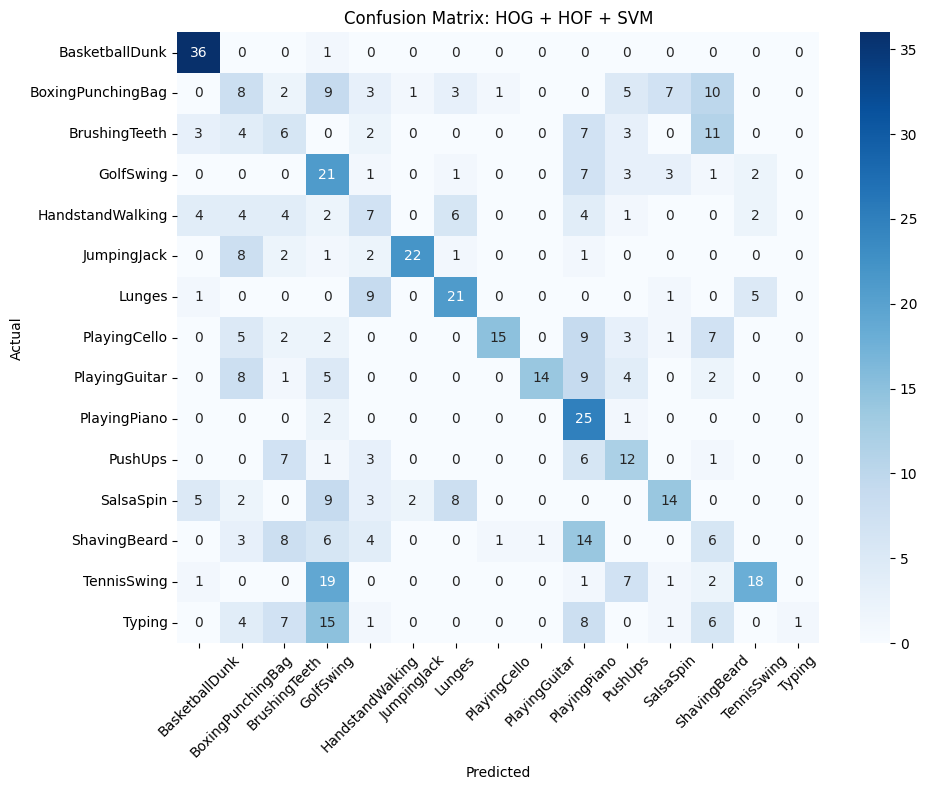

CPU times: user 5.41 s, sys: 130 ms, total: 5.54 s
Wall time: 36.9 s


In [ ]:
%%time
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load precomputed features
df_train = pd.read_pickle("/content/df_train.pkl")
df_test = pd.read_pickle("/content/df_test.pkl")

# Convert features to matrix form
X_train = np.vstack(df_train['feat'].values)
y_train = df_train['y'].values
X_test = np.vstack(df_test['feat'].values)
y_test = df_test['y'].values

# Step 1: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: PCA → 256D
pca = PCA(n_components=256, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("✅ PCA complete. Shape:", X_train_pca.shape)

# Step 3: GridSearchCV with SVM (RBF kernel)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1],
    'kernel': ['rbf']
}

print("🔍 Starting GridSearchCV...")
grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train_pca, y_train)

# Step 4: Evaluate best model
best_svm = grid.best_estimator_
y_pred = best_svm.predict(X_test_pca)

print(f"\n🎯 Test Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("📋 Classification Report:\n", classification_report(y_test, y_pred))

# Step 5: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df_train['label'].unique()),
            yticklabels=sorted(df_train['label'].unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: HOG + HOF + SVM")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 1.12: Retrain Final SVM and Evaluate on Test Set

1.12.1 Retrain Best SVM on Full Training Set

✅ Best Params: C=10, gamma=0.001

🎯 Test Accuracy (final model): 0.3818

📋 Classification Report:

                   precision    recall  f1-score   support

   BasketballDunk       0.72      0.97      0.83        37
BoxingPunchingBag       0.17      0.16      0.17        49
    BrushingTeeth       0.15      0.17      0.16        36
        GolfSwing       0.23      0.54      0.32        39
 HandstandWalking       0.20      0.21      0.20        34
      JumpingJack       0.88      0.59      0.71        37
           Lunges       0.53      0.57      0.55        37
     PlayingCello       0.88      0.34      0.49        44
    PlayingGuitar       0.93      0.33      0.48        43
     PlayingPiano       0.27      0.89      0.42        28
          PushUps       0.31      0.40      0.35        30
        SalsaSpin       0.50      0.33      0.39        43
     ShavingBeard       0.13      0.14      0.13        43
      TennisSwing       0.67      0.37      0.47        49
           Typi

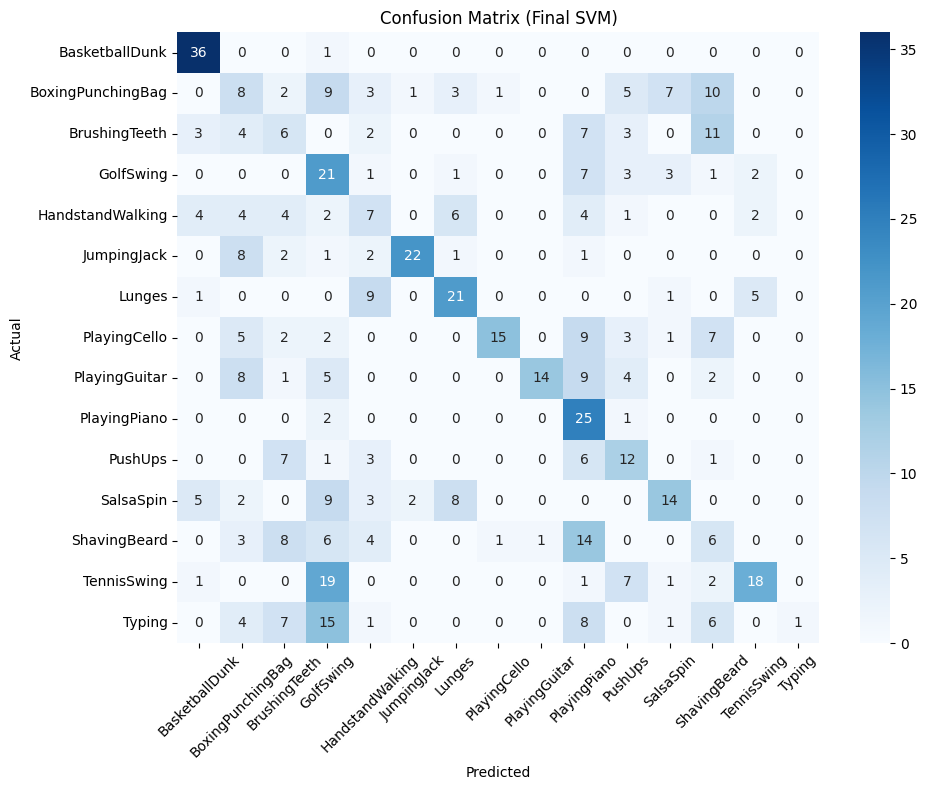

CPU times: user 1.23 s, sys: 8.23 ms, total: 1.23 s
Wall time: 1.24 s


,count
label,
PlayingCello,120
ShavingBeard,118
TennisSwing,117
PlayingGuitar,117
BoxingPunchingBag,114
GolfSwing,100
BrushingTeeth,95
BasketballDunk,94
Typing,93


In [ ]:
%%time
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 🔁 Use best parameters from GridSearchCV
best_params = grid.best_params_
print(f"✅ Best Params: C={best_params['C']}, gamma={best_params['gamma']}")

# 🧠 Retrain SVM using all training data
final_svm = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'])
final_svm.fit(X_train_pca, y_train)

# 🎯 Predict on official test set
y_pred = final_svm.predict(X_test_pca)

# ✅ Evaluation
print(f"\n🎯 Test Accuracy (final model): {accuracy_score(y_test, y_pred):.4f}")
print("\n📋 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 📊 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Final SVM)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

np.mean([np.mean(f) for f in df_train['feat'].values])

df_train['label'].value_counts()

IMPROVEMENT

## 1.14: Improve Model Accuracy with HOG + HOF Features and Expanded Hyperparameter Search

### 1.14.1 Extract HOG + HOF Features


In [ ]:
%%time
def extract_hog_hof_feature(video_path):
    hog_feat = video_hog(video_path)
    hof_feat = video_hof(video_path)
    return np.concatenate([hog_feat, hof_feat])

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 13.1 µs


### 1.14.2 Build Feature DataFrame with HOG + HOF

In [ ]:
%%time
df_train_improved = build_feature_df(train_videos, feature_extractor=extract_hog_hof_feature)
df_test_improved = build_feature_df(test_videos, feature_extractor=extract_hog_hof_feature)

100%|██████████| 592/592 [04:39<00:00,  2.12it/s]

CPU times: user 18min 5s, sys: 18.5 s, total: 18min 24s
Wall time: 16min 34s


### 1.14.3 Standardize and PCA

In [ ]:
%%time
X_train_improved = np.vstack(df_train_improved['feat'].values)
y_train_improved = df_train_improved['y'].values
X_test_improved = np.vstack(df_test_improved['feat'].values)
y_test_improved = df_test_improved['y'].values

scaler_improved = StandardScaler()
X_train_scaled_improved = scaler_improved.fit_transform(X_train_improved)
X_test_scaled_improved = scaler_improved.transform(X_test_improved)

pca_improved = PCA(n_components=256, whiten=True, random_state=42)
X_train_pca_improved = pca_improved.fit_transform(X_train_scaled_improved)
X_test_pca_improved = pca_improved.transform(X_test_scaled_improved)

CPU times: user 2.81 s, sys: 6.42 ms, total: 2.82 s
Wall time: 1.52 s


### 1.14.4 Expanded Hyperparameter Search

In [ ]:
%%time
param_grid_improved = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.001, 0.01, 0.1, 1, 10],
    'kernel': ['rbf', 'poly']
}

grid_improved = GridSearchCV(SVC(), param_grid_improved, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_improved.fit(X_train_pca_improved, y_train_improved)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: user 1.69 s, sys: 102 ms, total: 1.79 s
Wall time: 1min 11s


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf', 'poly']},
             scoring='accuracy', verbose=2)

### 1.14.5 Evaluate Improved Model

In [ ]:
%%time
best_svm_improved = grid_improved.best_estimator_
y_pred_improved = best_svm_improved.predict(X_test_pca_improved)

print(f"\nImproved Test Accuracy: {accuracy_score(y_test_improved, y_pred_improved):.4f}\n")
print("Improved Classification Report:\n", classification_report(y_test_improved, y_pred_improved))


Improved Test Accuracy: 0.3953

Improved Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88        37
           1       0.30      0.27      0.28        49
           2       0.13      0.14      0.13        36
           3       0.21      0.44      0.28        39
           4       0.14      0.15      0.14        34
           5       0.86      0.65      0.74        37
           6       0.56      0.62      0.59        37
           7       0.83      0.34      0.48        44
           8       0.93      0.33      0.48        43
           9       0.28      0.93      0.43        28
          10       0.34      0.40      0.37        30
          11       0.48      0.37      0.42        43
          12       0.12      0.14      0.13        43
          13       0.62      0.37      0.46        49
          14       1.00      0.09      0.17        43

    accuracy                           0.40       592
   macro avg  

### 1.14.6 Confusion Matrix for Improved Model

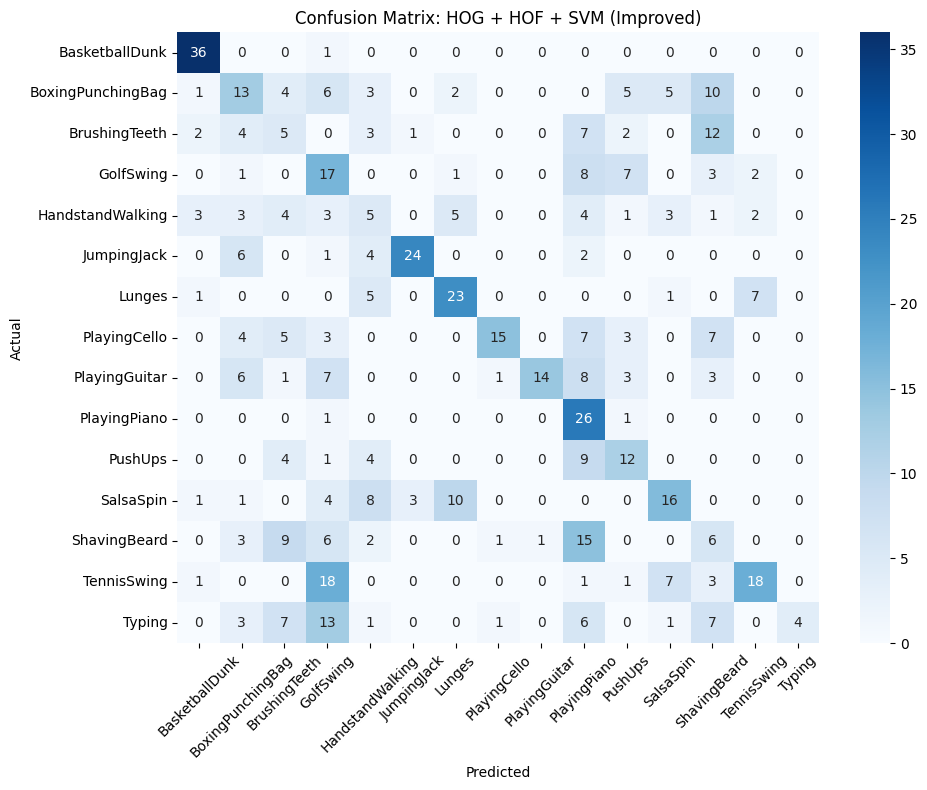

CPU times: user 688 ms, sys: 13.1 ms, total: 701 ms
Wall time: 698 ms


In [ ]:
%%time
cm_improved = confusion_matrix(y_test_improved, y_pred_improved)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_improved, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(df_train_improved['label'].unique()),
            yticklabels=sorted(df_train_improved['label'].unique()))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: HOG + HOF + SVM (Improved)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
print("\n--- Cleaning up variables from HOG+HOF Pipeline ---")
vars_to_delete = [
    'df_train', 'df_test', 'X_train', 'y_train', 'X_test', 'y_test',
    'X_train_scaled', 'X_test_scaled', 'X_train_pca', 'X_test_pca',
    'scaler', 'pca', 'grid', 'best_svm', 'final_svm',
    'df_train_improved', 'df_test_improved',
    'X_train_improved', 'y_train_improved', 'X_test_improved', 'y_test_improved',
    'scaler_improved', 'X_train_scaled_improved', 'X_test_scaled_improved',
    'pca_improved', 'X_train_pca_improved', 'X_test_pca_improved',
    'grid_improved', 'best_svm_improved',
    'filtered_data', 'filtered_test_set', # If these are large lists of paths
    'train_videos', 'test_videos', 'all_labels', # From their get_video_list
    # Any other large data structures they created
]
for var_name in vars_to_delete:
    if var_name in locals() or var_name in globals():
        print(f"Deleting {var_name}...")
        del globals()[var_name] # Or locals() if defined within a function scope not being reused
    # Or more simply, if you know they are global:
    # if var_name in globals():
    #     del globals()[var_name]


import gc
gc.collect()
print("HOG+HOF pipeline cleanup complete.")


--- Cleaning up variables from HOG+HOF Pipeline ---
Deleting df_train...
Deleting df_test...
Deleting X_train...
Deleting y_train...
Deleting X_test...
Deleting y_test...
Deleting X_train_scaled...
Deleting X_test_scaled...
Deleting X_train_pca...
Deleting X_test_pca...
Deleting scaler...
Deleting pca...
Deleting grid...
Deleting best_svm...
Deleting final_svm...
Deleting df_train_improved...
Deleting df_test_improved...
Deleting X_train_improved...
Deleting y_train_improved...
Deleting X_test_improved...
Deleting y_test_improved...
Deleting scaler_improved...
Deleting X_train_scaled_improved...
Deleting X_test_scaled_improved...
Deleting pca_improved...
Deleting X_train_pca_improved...
Deleting X_test_pca_improved...
Deleting grid_improved...
Deleting best_svm_improved...
Deleting filtered_test_set...
Deleting train_videos...
Deleting test_videos...
Deleting all_labels...
HOG+HOF pipeline cleanup complete.


# Section 2: STIP + BOVW + SVM Pipeline



## 1. Mounting drive, package import and set paths (already in Section 0)

## 2. Import selected data (15 actions) from drive and unzip action STIP files

In [ ]:
%%time
# --- COPY SUBSET FROM DRIVE TO COLAB LOCAL (Faster, Run Every Session) ---
# ... (previous parts of Stage 2 for creating local dirs and copying videos remain the same) ...

# --- IMPORTANT: Define your 15 CHOSEN CLASS NAMES HERE ---
CHOSEN_CLASSES = [
    'BasketballDunk', 'GolfSwing', 'TennisSwing',
    'PlayingPiano', 'PlayingGuitar', 'PlayingCello',
    'BrushingTeeth', 'Typing', 'ShavingBeard',
    'JumpingJack', 'Lunges', 'PushUps',
    'BoxingPunchingBag', 'SalsaSpin', 'HandstandWalking'
] # REPLACE WITH YOUR ACTUAL 15 CLASSES

LOCAL_DATA_ROOT = '/content/project_data_subset' # Local Colab directory
LOCAL_VIDEO_SUBSET_DIR = os.path.join(LOCAL_DATA_ROOT, 'UCF101_subset_videos')
LOCAL_STIP_SUBSET_DIR = os.path.join(LOCAL_DATA_ROOT, 'STIP_subset')
LOCAL_SPLITS_DIR_FOR_USE = os.path.join(LOCAL_DATA_ROOT, 'ucfTrainTestlist_subset') # For the actual list files

os.makedirs(LOCAL_DATA_ROOT, exist_ok=True)
os.makedirs(LOCAL_VIDEO_SUBSET_DIR, exist_ok=True)
os.makedirs(LOCAL_STIP_SUBSET_DIR, exist_ok=True)
os.makedirs(LOCAL_SPLITS_DIR_FOR_USE, exist_ok=True)

def copy_subset_from_drive_to_local(drive_source_base_dir, local_dest_base_dir, class_list):
    """Copies files for specified classes from Drive source to local Colab dest."""
    print(f"Copying subset from {drive_source_base_dir} to {local_dest_base_dir}...")
    if not os.path.exists(drive_source_base_dir):
        print(f"ERROR: Drive source directory {drive_source_base_dir} does not exist. Cannot copy subset.")
        print("Ensure Stage 1 (unzipping to Drive) was successful.")
        return

    for class_name in tqdm(class_list, desc=f"Copying {os.path.basename(drive_source_base_dir)}"):
        drive_class_dir = os.path.join(drive_source_base_dir, class_name)
        local_class_dir = os.path.join(local_dest_base_dir, class_name)

        if os.path.exists(local_class_dir) and os.listdir(local_class_dir):
            #print(f"Local class {class_name} already populated. Skipping copy.")
            continue # Skip if already copied in this session

        os.makedirs(local_class_dir, exist_ok=True)

        if not os.path.exists(drive_class_dir):
            print(f"Warning: Drive source class directory not found: {drive_class_dir}")
            continue

        for item_name in os.listdir(drive_class_dir):
            drive_item_path = os.path.join(drive_class_dir, item_name)
            local_item_path = os.path.join(local_class_dir, item_name)
            if os.path.isfile(drive_item_path):
                try:
                    shutil.copy2(drive_item_path, local_item_path)
                except Exception as e:
                    print(f"Error copying {drive_item_path} to {local_item_path}: {e}")
    print(f"Subset copy from {drive_source_base_dir} complete.")

# Copy video subset
if os.path.exists(DRIVE_UNZIPPED_VIDEOS): # Check if the unzipped video dir on Drive exists
    copy_subset_from_drive_to_local(DRIVE_UNZIPPED_VIDEOS, LOCAL_VIDEO_SUBSET_DIR, CHOSEN_CLASSES)
else:
    print(f"ERROR: Unzipped videos not found at {DRIVE_UNZIPPED_VIDEOS} on Drive. Run Stage 1.")




print("\n--- Copying and Filtering Train/Test Split Files ---")
DRIVE_UCF_LISTS_DIR = os.path.join(DRIVE_PROJECT_ROOT, 'UCF101_Unzipped', 'ucfTrainTestlist') # EXAMPLE - ADJUST THIS PATH

if not os.path.exists(DRIVE_UCF_LISTS_DIR):
    print(f"ERROR: Drive directory for UCF101 split lists not found: {DRIVE_UCF_LISTS_DIR}")
else:
    split_files_to_copy = ['trainlist01.txt', 'testlist01.txt', 'classInd.txt']
    for file_name in split_files_to_copy:
        drive_file_path = os.path.join(DRIVE_UCF_LISTS_DIR, file_name)
        local_file_path = os.path.join(LOCAL_SPLITS_DIR_FOR_USE, file_name)
        if os.path.exists(drive_file_path):
            if not os.path.exists(local_file_path): # Only copy if not already present
                print(f"  Copying {file_name} to {local_file_path}...")
                shutil.copy2(drive_file_path, local_file_path)
            # else:
                # print(f"  {file_name} already exists locally. Skipping copy.")

            # Filter the train/test list files for CHOSEN_CLASSES
            if file_name in ['trainlist01.txt', 'testlist01.txt']:
                print(f"  Filtering {local_file_path} for CHOSEN_CLASSES...")
                filtered_lines = []
                try:
                    with open(local_file_path, 'r') as f_in:
                        for line in f_in:
                            # Assuming format: ClassName/videoname.avi 1 (or just ClassName/videoname.avi)
                            class_name_from_list = line.strip().split('/')[0]
                            if class_name_from_list in CHOSEN_CLASSES:
                                filtered_lines.append(line)
                    # Overwrite the local file with filtered content
                    with open(local_file_path, 'w') as f_out:
                        f_out.writelines(filtered_lines)
                    print(f"    Filtered {file_name} contains {len(filtered_lines)} entries.")
                except Exception as e:
                    print(f"    Error filtering {file_name}: {e}")
        else:
            print(f"  Warning: Split file not found on Drive: {drive_file_path}")




# --- REVISED STAGE 2 STIP SUBSET COPYING (Handling ClassName.zip files) ---
print("\n--- Copying STIP ClassName.zip files from Google Drive (handling Part1/Part2 structure) ---")

# Ensure LOCAL_STIP_SUBSET_DIR, DRIVE_UNZIPPED_STIP, CHOSEN_CLASSES are defined

if 'LOCAL_STIP_SUBSET_DIR' not in locals() or not os.path.exists(LOCAL_STIP_SUBSET_DIR):
    print(f"ERROR: LOCAL_STIP_SUBSET_DIR not defined or does not exist. Cannot copy STIP.")
elif 'DRIVE_UNZIPPED_STIP' not in locals() or not os.path.exists(DRIVE_UNZIPPED_STIP):
    print(f"ERROR: DRIVE_UNZIPPED_STIP (Google Drive STIP base) not defined or does not exist. Cannot copy STIP.")
elif 'CHOSEN_CLASSES' not in locals() or not CHOSEN_CLASSES:
    print(f"ERROR: CHOSEN_CLASSES not defined or empty. Cannot copy STIP.")
else:
    stip_drive_source_part1 = os.path.join(DRIVE_UNZIPPED_STIP, 'Part1') # Case-sensitive for 'Part1'
    stip_drive_source_part2 = os.path.join(DRIVE_UNZIPPED_STIP, 'Part2') # Case-sensitive for 'Part2'
    stip_drive_sources_to_check = []
    copied_any_class_stip_zips = False

    # Check if Part1 exists
    if os.path.exists(stip_drive_source_part1) and os.path.isdir(stip_drive_source_part1):
        stip_drive_sources_to_check.append(stip_drive_source_part1)
        print(f"Found STIP source candidate: {stip_drive_source_part1}")
    else:
        print(f"WARNING: STIP source 'Part1' not found at {stip_drive_source_part1}. Check casing or if it exists.")

    # Check if Part2 exists
    if os.path.exists(stip_drive_source_part2) and os.path.isdir(stip_drive_source_part2):
        stip_drive_sources_to_check.append(stip_drive_source_part2)
        print(f"Found STIP source candidate: {stip_drive_source_part2}")
    else:
        print(f"WARNING: STIP source 'Part2' not found at {stip_drive_source_part2}. Check casing or if it exists.")

    if not stip_drive_sources_to_check:
        print(f"ERROR: Neither 'Part1' nor 'Part2' subdirectories found in {DRIVE_UNZIPPED_STIP}. Cannot copy STIP subset.")
    else:
        for class_name in tqdm(CHOSEN_CLASSES, desc="Copying STIP ClassName.zip files"):
            # For each chosen class, we will create a local directory for its STIP files
            local_class_stip_destination_dir = os.path.join(LOCAL_STIP_SUBSET_DIR, class_name)
            os.makedirs(local_class_stip_destination_dir, exist_ok=True) # Create local class dir for unzipping into

            class_zip_found_and_copied = False
            for drive_stip_part_dir in stip_drive_sources_to_check: # Check in Part1, then Part2
                # Construct the expected ZIP filename, e.g., BasketballDunk.zip
                expected_drive_zip_filename = class_name + ".zip"
                drive_zip_filepath = os.path.join(drive_stip_part_dir, expected_drive_zip_filename)

                # print(f"  Checking for Drive STIP ZIP: {drive_zip_filepath}") # DEBUG

                if os.path.exists(drive_zip_filepath) and os.path.isfile(drive_zip_filepath):
                    # print(f"    Found Drive STIP ZIP: {drive_zip_filepath}") # DEBUG
                    # Define where this ClassName.zip will be copied locally (inside its class folder)
                    local_zip_destination_path = os.path.join(local_class_stip_destination_dir, expected_drive_zip_filename)

                    if not os.path.exists(local_zip_destination_path):
                        try:
                            print(f"    Copying STIP ZIP '{drive_zip_filepath}' to '{local_zip_destination_path}'...")
                            shutil.copy2(drive_zip_filepath, local_zip_destination_path)
                            copied_any_class_stip_zips = True
                            class_zip_found_and_copied = True
                            break # Found the zip for this class in this part, move to next class_name
                        except Exception as e:
                            print(f"    ERROR copying STIP ZIP file {drive_zip_filepath} to {local_zip_destination_path}: {e}")
                    # else:
                        # print(f"    Local STIP ZIP '{local_zip_destination_path}' already exists. Skipping copy.") # DEBUG
                        # class_zip_found_and_copied = True # Count as found if already exists
                        # break # Already have it locally for this class

            if not class_zip_found_and_copied:
                #print(f"    WARNING: STIP ZIP file '{class_name}.zip' not found in any Drive STIP parts ({stip_drive_sources_to_check}).")
                print(f"     INFO: STIP ZIP file '{class_name}.zip' was not copied from Drive because it appears to be already present locally.")
        if copied_any_class_stip_zips:
            print(f"STIP ClassName.zip files copy to {LOCAL_STIP_SUBSET_DIR} (into class subfolders) seems to have copied some files.")
        elif any(os.listdir(d) for d in [os.path.join(LOCAL_STIP_SUBSET_DIR, c) for c in CHOSEN_CLASSES if os.path.exists(os.path.join(LOCAL_STIP_SUBSET_DIR, c))]):
            print(f"STIP ClassName.zip files seem to be already present in {LOCAL_STIP_SUBSET_DIR} (in class subfolders). No new files copied.")
        else:
            print(f"WARNING: STIP ClassName.zip files copy did NOT copy any new ZIP files. Check Drive contents and CHOSEN_CLASSES names.")

if not copied_any_class_stip_zips and not any(os.listdir(d) for d in [os.path.join(LOCAL_STIP_SUBSET_DIR, c) for c in CHOSEN_CLASSES if os.path.exists(os.path.join(LOCAL_STIP_SUBSET_DIR, c))]):
    print("Ensure 'Part1' and 'Part2' exist in DRIVE_UNZIPPED_STIP and contain 'ClassName.zip' files matching CHOSEN_CLASSES.")



# --- Define Global Paths for Subsequent Stages ---
VIDEO_DIR = LOCAL_VIDEO_SUBSET_DIR
TRAIN_LIST_PATH = os.path.join(LOCAL_SPLITS_DIR_FOR_USE, 'trainlist01.txt')
TEST_LIST_PATH = os.path.join(LOCAL_SPLITS_DIR_FOR_USE, 'testlist01.txt')
CLASS_IND_PATH = os.path.join(LOCAL_SPLITS_DIR_FOR_USE, 'classInd.txt') # Optional, but good to have

print(f"\n--- STAGE 2: FINAL PATHS DEFINED FOR NEXT STAGES ---")
print(f"VIDEO_DIR (for video files): {VIDEO_DIR}")
print(f"TRAIN_LIST_PATH (for training list): {TRAIN_LIST_PATH}")
print(f"TEST_LIST_PATH (for testing list): {TEST_LIST_PATH}")
if os.path.exists(CLASS_IND_PATH):
    print(f"CLASS_IND_PATH (for class indices): {CLASS_IND_PATH}")

# Sanity check that these files now exist (important after copy & filter)
for p in [VIDEO_DIR, TRAIN_LIST_PATH, TEST_LIST_PATH]:
    if not os.path.exists(p):
        print(f"  WARNING: Path defined but does not exist: {p}. Check Stage 2 copying steps.")
    elif p == VIDEO_DIR and (not os.listdir(p) if os.path.isdir(p) else True):
         print(f"  WARNING: VIDEO_DIR {p} exists but is empty. Check video copy.")
print("--- End of Stage 2 ---")



# --- Unzip Per-Class STIP ZIP files locally ---

# LOCAL_STIP_SUBSET_DIR should be defined from Stage 2,
# e.g., LOCAL_STIP_SUBSET_DIR = '/content/project_data_subset/STIP_subset'
# CHOSEN_CLASSES should also be defined.

print(f"\n--- Unzipping per-class STIP ZIP files in {LOCAL_STIP_SUBSET_DIR} ---")

if 'LOCAL_STIP_SUBSET_DIR' not in locals() or not os.path.exists(LOCAL_STIP_SUBSET_DIR):
    print(f"ERROR: LOCAL_STIP_SUBSET_DIR ('{locals().get('LOCAL_STIP_SUBSET_DIR', 'Not Defined')}') does not exist. Cannot unzip STIP zips.")
else:
    stip_classes_unzipped_count = 0
    for class_name in CHOSEN_CLASSES:
        local_class_stip_dir = os.path.join(LOCAL_STIP_SUBSET_DIR, class_name)
        if os.path.exists(local_class_stip_dir) and os.path.isdir(local_class_stip_dir):
            zip_files_found = [f for f in os.listdir(local_class_stip_dir) if f.lower().endswith('.zip')]

            if not zip_files_found:
                # It's possible this class had loose STIP files already, or no zip was copied
                # Let's check for loose .stip or .txt files as a fallback for this class
                loose_stip_files = [f for f in os.listdir(local_class_stip_dir)
                                    if os.path.isfile(os.path.join(local_class_stip_dir, f))
                                    and (f.lower().endswith('.stip') or f.lower().endswith('.txt'))]
                if loose_stip_files:
                    # print(f"Class '{class_name}': Found {len(loose_stip_files)} loose STIP files, no new ZIPs to unzip.")
                    stip_classes_unzipped_count+=1 # Count it as processed
                # else:
                    # print(f"Class '{class_name}': No ZIP files found and no loose STIP files detected.")
                continue # Move to the next class

            for zip_filename in zip_files_found:
                zip_filepath = os.path.join(local_class_stip_dir, zip_filename)
                # Check if it has already been unzipped (e.g., by looking for a marker or specific files)
                # For simplicity, we'll just unzip. If files exist, zipfile extractall might overwrite.
                # A more robust check would be to see if non-zip files exist.
                has_non_zip_files = any(not f.lower().endswith('.zip') for f in os.listdir(local_class_stip_dir))

                if has_non_zip_files and len(os.listdir(local_class_stip_dir)) > len(zip_files_found) : # Simple check: more files than zips
                    print(f"Class '{class_name}', ZIP '{zip_filename}': Appears to be already unzipped (found non-ZIP files). Skipping unzipping.")
                    stip_classes_unzipped_count+=1
                    continue

                print(f"Class '{class_name}': Unzipping '{zip_filename}' in '{local_class_stip_dir}'...")
                try:
                    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                        zip_ref.extractall(local_class_stip_dir)
                    print(f"   Successfully unzipped '{zip_filename}'.")
                    stip_classes_unzipped_count+=1
                    # Optionally, delete the zip file after successful extraction to save space / avoid re-processing
                    # os.remove(zip_filepath)
                    # print(f"   Deleted '{zip_filename}'.")
                except Exception as e:
                    print(f"   ERROR unzipping '{zip_filename}': {e}")
        # else:
             # This class folder wasn't even created locally, Stage 2 STIP copy probably missed it.
             # print(f"Class '{class_name}': STIP folder not found at '{local_class_stip_dir}'.")

    if stip_classes_unzipped_count == len(CHOSEN_CLASSES):
        print(f"Successfully processed/unzipped STIP for all {len(CHOSEN_CLASSES)} chosen classes.")
    else:
        print(f"Warning: Processed/unzipped STIP for {stip_classes_unzipped_count} out of {len(CHOSEN_CLASSES)} chosen classes. Check logs.")

print("--- STIP per-class ZIP unzipping complete (if any zips were found). ---")

Copying subset from /content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/UCF-101 to /content/project_data_subset/UCF101_subset_videos...


Copying UCF-101: 100%|██████████| 15/15 [01:23<00:00,  5.58s/it]


Subset copy from /content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/UCF-101 complete.

--- Copying and Filtering Train/Test Split Files ---
  Copying trainlist01.txt to /content/project_data_subset/ucfTrainTestlist_subset/trainlist01.txt...
  Filtering /content/project_data_subset/ucfTrainTestlist_subset/trainlist01.txt for CHOSEN_CLASSES...
    Filtered trainlist01.txt contains 1460 entries.
  Copying testlist01.txt to /content/project_data_subset/ucfTrainTestlist_subset/testlist01.txt...
  Filtering /content/project_data_subset/ucfTrainTestlist_subset/testlist01.txt for CHOSEN_CLASSES...
    Filtered testlist01.txt contains 592 entries.
  Copying classInd.txt to /content/project_data_subset/ucfTrainTestlist_subset/classInd.txt...

--- Copying STIP ClassName.zip files from Google Drive (handling Part1/Part2 structure) ---
Found STIP source candidate: /content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1
Fou

Copying STIP ClassName.zip files:   0%|          | 0/15 [00:00<?, ?it/s]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part2/BasketballDunk.zip' to '/content/project_data_subset/STIP_subset/BasketballDunk/BasketballDunk.zip'...


Copying STIP ClassName.zip files:   7%|▋         | 1/15 [00:03<00:46,  3.32s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1/GolfSwing.zip' to '/content/project_data_subset/STIP_subset/GolfSwing/GolfSwing.zip'...


Copying STIP ClassName.zip files:  13%|█▎        | 2/15 [00:05<00:31,  2.39s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1/TennisSwing.zip' to '/content/project_data_subset/STIP_subset/TennisSwing/TennisSwing.zip'...


Copying STIP ClassName.zip files:  20%|██        | 3/15 [00:09<00:41,  3.48s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1/PlayingPiano.zip' to '/content/project_data_subset/STIP_subset/PlayingPiano/PlayingPiano.zip'...


Copying STIP ClassName.zip files:  27%|██▋       | 4/15 [00:10<00:27,  2.49s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1/PlayingGuitar.zip' to '/content/project_data_subset/STIP_subset/PlayingGuitar/PlayingGuitar.zip'...


Copying STIP ClassName.zip files:  33%|███▎      | 5/15 [00:15<00:32,  3.29s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part2/PlayingCello.zip' to '/content/project_data_subset/STIP_subset/PlayingCello/PlayingCello.zip'...


Copying STIP ClassName.zip files:  40%|████      | 6/15 [00:18<00:29,  3.30s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part2/BrushingTeeth.zip' to '/content/project_data_subset/STIP_subset/BrushingTeeth/BrushingTeeth.zip'...


Copying STIP ClassName.zip files:  47%|████▋     | 7/15 [00:22<00:28,  3.52s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part2/Typing.zip' to '/content/project_data_subset/STIP_subset/Typing/Typing.zip'...


Copying STIP ClassName.zip files:  53%|█████▎    | 8/15 [00:25<00:23,  3.29s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part2/ShavingBeard.zip' to '/content/project_data_subset/STIP_subset/ShavingBeard/ShavingBeard.zip'...


Copying STIP ClassName.zip files:  60%|██████    | 9/15 [00:31<00:25,  4.22s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1/JumpingJack.zip' to '/content/project_data_subset/STIP_subset/JumpingJack/JumpingJack.zip'...


Copying STIP ClassName.zip files:  67%|██████▋   | 10/15 [00:34<00:18,  3.63s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1/Lunges.zip' to '/content/project_data_subset/STIP_subset/Lunges/Lunges.zip'...


Copying STIP ClassName.zip files:  73%|███████▎  | 11/15 [00:42<00:20,  5.01s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1/PushUps.zip' to '/content/project_data_subset/STIP_subset/PushUps/PushUps.zip'...


Copying STIP ClassName.zip files:  80%|████████  | 12/15 [00:43<00:11,  3.87s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part2/BoxingPunchingBag.zip' to '/content/project_data_subset/STIP_subset/BoxingPunchingBag/BoxingPunchingBag.zip'...


Copying STIP ClassName.zip files:  87%|████████▋ | 13/15 [00:49<00:08,  4.44s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part1/SalsaSpin.zip' to '/content/project_data_subset/STIP_subset/SalsaSpin/SalsaSpin.zip'...


Copying STIP ClassName.zip files:  93%|█████████▎| 14/15 [00:53<00:04,  4.40s/it]

    Copying STIP ZIP '/content/drive/MyDrive/Machine Learning COS80027 - Final Project/UCF101_Unzipped/STIP_AllClasses/Part2/HandstandWalking.zip' to '/content/project_data_subset/STIP_subset/HandstandWalking/HandstandWalking.zip'...


Copying STIP ClassName.zip files: 100%|██████████| 15/15 [00:55<00:00,  3.73s/it]


STIP ClassName.zip files copy to /content/project_data_subset/STIP_subset (into class subfolders) seems to have copied some files.

--- STAGE 2: FINAL PATHS DEFINED FOR NEXT STAGES ---
VIDEO_DIR (for video files): /content/project_data_subset/UCF101_subset_videos
TRAIN_LIST_PATH (for training list): /content/project_data_subset/ucfTrainTestlist_subset/trainlist01.txt
TEST_LIST_PATH (for testing list): /content/project_data_subset/ucfTrainTestlist_subset/testlist01.txt
CLASS_IND_PATH (for class indices): /content/project_data_subset/ucfTrainTestlist_subset/classInd.txt
--- End of Stage 2 ---

--- Unzipping per-class STIP ZIP files in /content/project_data_subset/STIP_subset ---
Class 'BasketballDunk': Unzipping 'BasketballDunk.zip' in '/content/project_data_subset/STIP_subset/BasketballDunk'...
   Successfully unzipped 'BasketballDunk.zip'.
Class 'GolfSwing': Unzipping 'GolfSwing.zip' in '/content/project_data_subset/STIP_subset/GolfSwing'...
   Successfully unzipped 'GolfSwing.zip'.
Cl

## 3. Function to Parse STIP Class Files and Extract Descriptors per Video

In [ ]:
%%time
# --- Cell 1: STIP Parsing Function ---
import re

def parse_stip_class_file(filepath):
    """
    Parses a STIP class file (e.g., BasketballDunk.txt) and extracts descriptors
    for each video mentioned in the file.

    Returns:
        dict: {video_filename_stem: [list_of_162d_descriptors_for_this_video]}
              e.g., {'v_BasketballDunk_g01_c01': [np.array(...), np.array(...)]}
    """
    video_stip_data = {}
    current_video_stem = None
    # Regex to capture the video filename stem from lines like:
    # '# UCF-100/BasketballDunk/v_BasketballDunk_g01_c01' or
    # '# ../videos_all_classes/Bowling/v_Bowling_g25_c07.avi' (another common format)
    video_id_pattern = re.compile(r"# .*[/|\\]([^/|\\]+?)(?:\.avi)?$")


    print(f"  Parsing STIP file: {filepath}")
    try:
        with open(filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue

                match = video_id_pattern.match(line)
                if match:
                    current_video_stem = match.group(1)
                    # print(f"    Found video: {current_video_stem}") # DEBUG
                    if current_video_stem not in video_stip_data:
                        video_stip_data[current_video_stem] = []
                elif line.startswith('#'): # Other comment line, skip
                    continue
                elif current_video_stem: # This is a data line for the current video
                    parts = line.split()
                    try:
                        # First 9 parts are metadata, next 72 HOG, next 90 HOF
                        # descriptor = np.array([float(p) for p in parts[9:9+162]], dtype=np.float32)
                        # Let's be more specific based on HOG(72) and HOF(90)
                        hog_dscr = np.array([float(p) for p in parts[9 : 9+72]], dtype=np.float32)
                        hof_dscr = np.array([float(p) for p in parts[9+72 : 9+72+90]], dtype=np.float32)

                        if len(hog_dscr) == 72 and len(hof_dscr) == 90:
                            # You can choose to use HOG, HOF, or both. Let's concatenate for now.
                            full_descriptor = np.concatenate((hog_dscr, hof_dscr))
                            video_stip_data[current_video_stem].append(full_descriptor)
                        # else:
                            # print(f"    Warning: Descriptor length mismatch in {filepath} for video {current_video_stem}. Line: {line[:50]}...")
                    except ValueError:
                        # print(f"    Warning: Could not parse descriptor data in {filepath} for video {current_video_stem}. Line: {line[:50]}...")
                        pass # Skip malformed lines
    except Exception as e:
        print(f"  ERROR reading or parsing STIP file {filepath}: {e}")

    # Filter out videos that ended up with no descriptors
    video_stip_data_filtered = {k: v for k, v in video_stip_data.items() if v}
    # print(f"  Finished parsing. Found STIPs for {len(video_stip_data_filtered)} videos in this file.")
    return video_stip_data_filtered

# --- Test the parser on one file (optional, but good for debugging) ---
# Ensure CHOSEN_CLASSES and LOCAL_STIP_SUBSET_DIR are defined
if 'CHOSEN_CLASSES' in locals() and CHOSEN_CLASSES and \
   'LOCAL_STIP_SUBSET_DIR' in locals() and os.path.exists(LOCAL_STIP_SUBSET_DIR):

    test_class = CHOSEN_CLASSES[0]
    test_class_stip_dir = os.path.join(LOCAL_STIP_SUBSET_DIR, test_class)

    # Find the actual STIP data file (e.g., BasketballDunk.txt, not a zip)
    stip_data_files = [f for f in os.listdir(test_class_stip_dir)
                       if os.path.isfile(os.path.join(test_class_stip_dir, f)) and not f.lower().endswith('.zip')]

    if stip_data_files:
        test_stip_file_path = os.path.join(test_class_stip_dir, stip_data_files[0])
        print(f"Testing parser with: {test_stip_file_path}")
        parsed_data_sample = parse_stip_class_file(test_stip_file_path)

        if parsed_data_sample:
            first_video_key = list(parsed_data_sample.keys())[0]
            print(f"Sample parsed data for video '{first_video_key}':")
            print(f"  Number of STIP descriptors: {len(parsed_data_sample[first_video_key])}")
            if parsed_data_sample[first_video_key]:
                 print(f"  Shape of first descriptor: {parsed_data_sample[first_video_key][0].shape}")
                 print(f"  First descriptor sample: {parsed_data_sample[first_video_key][0][:10]}...") # Print first 10 values
        else:
            print("Parser test did not return any data.")
    else:
        print(f"No STIP data file found in {test_class_stip_dir} to test parser.")
else:
    print("CHOSEN_CLASSES or LOCAL_STIP_SUBSET_DIR not set for parser test.")

Testing parser with: /content/project_data_subset/STIP_subset/BasketballDunk/BasketballDunk.txt
  Parsing STIP file: /content/project_data_subset/STIP_subset/BasketballDunk/BasketballDunk.txt
Sample parsed data for video 'v_BasketballDunk_g01_c01':
  Number of STIP descriptors: 1677
  Shape of first descriptor: (162,)
  First descriptor sample: [0.150301  0.270415  0.276457  0.302827  0.0651722 0.0996801 0.217578
 0.61757   0.281713  0.307512 ]...
CPU times: user 15.4 s, sys: 538 ms, total: 16 s
Wall time: 16.4 s


## 4. Load Video Lists and Labels

In [ ]:
%%time
# --- Cell: Load Video Lists and Labels (Prerequisite for STIP Processing & CNN) ---

# Ensure CHOSEN_CLASSES, VIDEO_DIR, TRAIN_LIST_PATH, TEST_LIST_PATH are correctly defined
# from the successful completion of STAGE 2.
# Ensure LabelEncoder is imported: from sklearn.preprocessing import LabelEncoder

print("--- Running: Load Video Lists and Labels ---")

# Make sure these crucial paths defined at the end of your Stage 2 are correct and accessible
# VIDEO_DIR = '/content/project_data_subset/UCF101_subset_videos'
# TRAIN_LIST_PATH = '/content/project_data_subset/ucfTrainTestlist_subset/trainlist01.txt'
# TEST_LIST_PATH = '/content/project_data_subset/ucfTrainTestlist_subset/testlist01.txt'
# CHOSEN_CLASSES = [...] # Your list

# Sanity check paths
if 'VIDEO_DIR' not in locals() or not os.path.exists(VIDEO_DIR):
    print(f"ERROR: VIDEO_DIR ('{locals().get('VIDEO_DIR', 'Not Defined')}') does not exist. Halting.")
    raise FileNotFoundError("VIDEO_DIR not found for loading video lists.")
if 'TRAIN_LIST_PATH' not in locals() or not os.path.exists(TRAIN_LIST_PATH):
    print(f"ERROR: TRAIN_LIST_PATH ('{locals().get('TRAIN_LIST_PATH', 'Not Defined')}') does not exist. Halting.")
    raise FileNotFoundError("TRAIN_LIST_PATH not found for loading video lists.")
if 'TEST_LIST_PATH' not in locals() or not os.path.exists(TEST_LIST_PATH):
    print(f"ERROR: TEST_LIST_PATH ('{locals().get('TEST_LIST_PATH', 'Not Defined')}') does not exist. Halting.")
    raise FileNotFoundError("TEST_LIST_PATH not found for loading video lists.")
if 'CHOSEN_CLASSES' not in locals() or not CHOSEN_CLASSES:
    print(f"ERROR: CHOSEN_CLASSES not defined. Halting.")
    raise ValueError("CHOSEN_CLASSES not defined for loading video lists.")

def load_video_list_and_labels(list_file_path, video_base_dir, chosen_classes_list):
    video_paths = []
    labels_text = []
    print(f"  Loading video list from: {list_file_path}")
    with open(list_file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line: continue
            parts = line.split()
            relative_video_path_from_list = parts[0]
            class_name_from_path = relative_video_path_from_list.split('/')[0]

            if class_name_from_path in chosen_classes_list:
                full_video_path = os.path.join(video_base_dir, relative_video_path_from_list)
                if os.path.exists(full_video_path):
                    video_paths.append(full_video_path)
                    labels_text.append(class_name_from_path)
                # else:
                    # print(f"    Warning: Video path from list not found locally: {full_video_path}")
    print(f"    Found {len(video_paths)} videos for {len(set(labels_text))} unique chosen classes in {os.path.basename(list_file_path)}.")
    return video_paths, labels_text

# Load train and test video paths and their string labels
train_video_paths, train_labels_text = load_video_list_and_labels(TRAIN_LIST_PATH, VIDEO_DIR, CHOSEN_CLASSES)
test_video_paths, test_labels_text = load_video_list_and_labels(TEST_LIST_PATH, VIDEO_DIR, CHOSEN_CLASSES)

if not train_video_paths or not test_video_paths:
    print("ERROR: Critical failure in loading training or testing video lists. Some STIP/CNN processing might fail.")
else:
    print(f"Total training videos in list for chosen classes: {len(train_video_paths)}")
    print(f"Total testing videos in list for chosen classes: {len(test_video_paths)}")

    # --- Label Encoding ---
    label_encoder = LabelEncoder()
    label_encoder.fit(CHOSEN_CLASSES) # Fit on the master list of chosen classes

    train_labels_encoded = label_encoder.transform(train_labels_text)
    test_labels_encoded = label_encoder.transform(test_labels_text)

    print("Label Encoder Classes (master list used for fitting):", label_encoder.classes_)
    print(f"Number of unique classes in training labels: {len(np.unique(train_labels_encoded))}")
    print(f"Number of unique classes in testing labels: {len(np.unique(test_labels_encoded))}")
    print("--- Video Lists and Labels Loaded Successfully ---")

--- Running: Load Video Lists and Labels ---
  Loading video list from: /content/project_data_subset/ucfTrainTestlist_subset/trainlist01.txt
    Found 1460 videos for 15 unique chosen classes in trainlist01.txt.
  Loading video list from: /content/project_data_subset/ucfTrainTestlist_subset/testlist01.txt
    Found 592 videos for 15 unique chosen classes in testlist01.txt.
Total training videos in list for chosen classes: 1460
Total testing videos in list for chosen classes: 592
Label Encoder Classes (master list used for fitting): ['BasketballDunk' 'BoxingPunchingBag' 'BrushingTeeth' 'GolfSwing'
 'HandstandWalking' 'JumpingJack' 'Lunges' 'PlayingCello' 'PlayingGuitar'
 'PlayingPiano' 'PushUps' 'SalsaSpin' 'ShavingBeard' 'TennisSwing'
 'Typing']
Number of unique classes in training labels: 15
Number of unique classes in testing labels: 15
--- Video Lists and Labels Loaded Successfully ---
CPU times: user 15.7 ms, sys: 8.64 ms, total: 24.3 ms
Wall time: 42.9 ms


## 5. Collect All STIP Descriptors from Training Videos

In [ ]:
%%time
# --- Cell 2: Collect All Training STIP Descriptors ---
# Ensure train_video_paths is defined and contains full paths to training videos.
# Ensure CHOSEN_CLASSES and LOCAL_STIP_SUBSET_DIR are defined.
# Ensure label_encoder is fitted and train_labels_text is available if you need to map back to class names.

all_train_stip_descriptors = []
stip_descriptors_per_train_video = {} # To store {video_path: [descriptors]} for BoVW encoding later

# We need a way to know which STIP class file to open for a given training video.
# We can parse the class name from train_video_paths.

# First, parse all STIP class files and store them in a dictionary for quick lookup
# This avoids re-parsing the large class STIP files multiple times.
all_class_stip_data_parsed = {} # {class_name: {video_stem: [descriptors]}}

print("\n--- Pre-parsing all STIP class files ---")
for class_name in tqdm(CHOSEN_CLASSES, desc="Parsing STIP class files"):
    class_stip_dir = os.path.join(LOCAL_STIP_SUBSET_DIR, class_name)
    if os.path.exists(class_stip_dir) and os.path.isdir(class_stip_dir):
        # Find the STIP data file (e.g., ClassName.txt)
        stip_data_files = [f for f in os.listdir(class_stip_dir)
                           if os.path.isfile(os.path.join(class_stip_dir, f)) and not f.lower().endswith('.zip')]
        if stip_data_files:
            stip_file_path = os.path.join(class_stip_dir, stip_data_files[0])
            all_class_stip_data_parsed[class_name] = parse_stip_class_file(stip_file_path)
        else:
            print(f"Warning: No STIP data file found for class '{class_name}' in {class_stip_dir}")

print(f"Pre-parsing complete. Found data for {len(all_class_stip_data_parsed)} classes.")

print("\n--- Collecting STIP descriptors from training videos ---")
# Ensure train_video_paths is defined from your data loading step for videos
if 'train_video_paths' not in locals() or not train_video_paths:
    print("ERROR: train_video_paths is not defined. Please run the data loading cell that defines it.")
    # If you need to regenerate it without full CNN feature extraction, you can use:
    # train_video_paths, train_labels_text = load_video_list_and_labels(TRAIN_LIST_PATH, VIDEO_DIR, CHOSEN_CLASSES)
    # This assumes load_video_list_and_labels, TRAIN_LIST_PATH, VIDEO_DIR, CHOSEN_CLASSES are available
else:
    for video_path in tqdm(train_video_paths, desc="Processing training videos for STIP"):
        video_filename = os.path.basename(video_path)       # e.g., v_BasketballDunk_g01_c01.avi
        video_stem = os.path.splitext(video_filename)[0]   # e.g., v_BasketballDunk_g01_c01

        # Determine class from video_path (assuming structure like .../ClassName/video.avi)
        class_name_from_video_path = os.path.basename(os.path.dirname(video_path))

        if class_name_from_video_path in all_class_stip_data_parsed:
            class_specific_stips = all_class_stip_data_parsed[class_name_from_video_path]
            if video_stem in class_specific_stips:
                video_descriptors = class_specific_stips[video_stem]
                if video_descriptors: # If list is not empty
                    all_train_stip_descriptors.extend(video_descriptors)
                    stip_descriptors_per_train_video[video_path] = video_descriptors # Store for BoVW
            # else:
                # print(f"  Warning: STIPs for video stem '{video_stem}' not found in parsed data for class '{class_name_from_video_path}'.")
        # else:
            # print(f"  Warning: Parsed STIP data for class '{class_name_from_video_path}' not found (from video {video_path}).")


if not all_train_stip_descriptors:
    print("ERROR: No STIP descriptors were collected from training videos. BoVW cannot proceed.")
    print("Check STIP file parsing, video paths, and if STIPs are present for training videos.")
else:
    all_train_stip_descriptors = np.vstack(all_train_stip_descriptors)
    print(f"\nCollected a total of {all_train_stip_descriptors.shape[0]} STIP descriptors from the training set.")
    print(f"Shape of all_train_stip_descriptors: {all_train_stip_descriptors.shape}") # Should be (N_total_stips, 162)


# --- End of Cell 2: Clean up large intermediate dictionaries/lists ---
if 'all_class_stip_data_parsed' in locals():
    print("Cell 2: Deleting 'all_class_stip_data_parsed' to free RAM.")
    del all_class_stip_data_parsed
if 'stip_descriptors_per_train_video' in locals(): # You used this in Cell 2
    print("Cell 2: Deleting 'stip_descriptors_per_train_video' to free RAM.")
    del stip_descriptors_per_train_video
# 'all_train_stip_descriptors' is needed by Cell 3, so we keep it for now.
# If you created 'all_train_stip_descriptors' from a list like 'all_train_stip_descriptors_list'
# before vstacking, delete that list too if it's still around.
# (Your Cell 2 code directly extends a list and then vstacks, so the list becomes the array)

import gc
gc.collect()
print("Cell 2: RAM cleanup attempted.")


--- Pre-parsing all STIP class files ---


Parsing STIP class files:   0%|          | 0/15 [00:00<?, ?it/s]

  Parsing STIP file: /content/project_data_subset/STIP_subset/BasketballDunk/BasketballDunk.txt


Parsing STIP class files:   7%|▋         | 1/15 [00:15<03:38, 15.62s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/GolfSwing/GolfSwing.txt


Parsing STIP class files:  13%|█▎        | 2/15 [00:22<02:12, 10.21s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/TennisSwing/TennisSwing.txt


Parsing STIP class files:  20%|██        | 3/15 [00:32<02:06, 10.55s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/PlayingPiano/PlayingPiano.txt


Parsing STIP class files:  27%|██▋       | 4/15 [00:36<01:24,  7.67s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/PlayingGuitar/PlayingGuitar.txt


Parsing STIP class files:  33%|███▎      | 5/15 [01:03<02:25, 14.58s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/PlayingCello/PlayingCello.txt


Parsing STIP class files:  40%|████      | 6/15 [01:19<02:16, 15.14s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/BrushingTeeth/BrushingTeeth.txt


Parsing STIP class files:  47%|████▋     | 7/15 [01:47<02:34, 19.30s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/Typing/Typing.txt


Parsing STIP class files:  53%|█████▎    | 8/15 [02:04<02:11, 18.72s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/ShavingBeard/ShavingBeard.txt


Parsing STIP class files:  60%|██████    | 9/15 [02:26<01:58, 19.67s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/JumpingJack/JumpingJack.txt


Parsing STIP class files:  67%|██████▋   | 10/15 [02:34<01:19, 15.96s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/Lunges/Lunges.txt


Parsing STIP class files:  73%|███████▎  | 11/15 [03:23<01:45, 26.26s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/PushUps/PushUps.txt


Parsing STIP class files:  80%|████████  | 12/15 [03:29<01:00, 20.08s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/BoxingPunchingBag/BoxingPunchingBag.txt


Parsing STIP class files:  87%|████████▋ | 13/15 [04:16<00:56, 28.15s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/SalsaSpin/SalsaSpin.txt


Parsing STIP class files:  93%|█████████▎| 14/15 [04:51<00:30, 30.38s/it]

  Parsing STIP file: /content/project_data_subset/STIP_subset/HandstandWalking/HandstandWalking.txt


Parsing STIP class files: 100%|██████████| 15/15 [05:08<00:00, 20.60s/it]


Pre-parsing complete. Found data for 15 classes.

--- Collecting STIP descriptors from training videos ---


Processing training videos for STIP: 100%|██████████| 1460/1460 [00:00<00:00, 11291.75it/s]



Collected a total of 4056969 STIP descriptors from the training set.
Shape of all_train_stip_descriptors: (4056969, 162)
Cell 2: Deleting 'all_class_stip_data_parsed' to free RAM.
Cell 2: Deleting 'stip_descriptors_per_train_video' to free RAM.
Cell 2: RAM cleanup attempted.
CPU times: user 5min 8s, sys: 16.5 s, total: 5min 25s
Wall time: 5min 31s


## 6. Build Visual Vocabulary with K-Means

In [ ]:
%%time
# --- Cell 3: Build Visual Vocabulary (K-Means Clustering) ---
from sklearn.cluster import KMeans
import numpy as np # Ensure numpy is imported
import os
from joblib import dump # For saving the model

# Ensure all_train_stip_descriptors is populated from Cell 2 and is not empty.
if 'all_train_stip_descriptors' in locals() and all_train_stip_descriptors.shape[0] > 0:
    # Hyperparameter: Number of visual words (clusters)
    K_VOCAB_SIZE = 500
    print(f"\nBuilding STIP visual vocabulary with K={K_VOCAB_SIZE} clusters...")

    num_total_descriptors = all_train_stip_descriptors.shape[0]
    print(f"Total descriptors available: {num_total_descriptors}")

    # --- SUBSAMPLING LOGIC ---
    # Define a maximum number of descriptors to use for K-Means
    # Adjust this value if you still run out of RAM.
    # Start with 300k, can go down to 100k or even 50k if necessary.
    MAX_DESCRIPTORS_FOR_KMEANS = 100000

    if num_total_descriptors > MAX_DESCRIPTORS_FOR_KMEANS:
        print(f"Subsampling descriptors from {num_total_descriptors} to {MAX_DESCRIPTORS_FOR_KMEANS} for K-Means...")
        sample_indices = np.random.choice(num_total_descriptors, size=MAX_DESCRIPTORS_FOR_KMEANS, replace=False)
        descriptors_for_kmeans = all_train_stip_descriptors[sample_indices]
    else:
        print("Using all available descriptors for K-Means.")
        descriptors_for_kmeans = all_train_stip_descriptors

    print(f"Shape of descriptors being used for K-Means: {descriptors_for_kmeans.shape}")

    # Check for NaNs or Infs in the subset being used (good practice)
    if np.isnan(descriptors_for_kmeans).any() or np.isinf(descriptors_for_kmeans).any():
        print("ERROR: Descriptors for K-Means contain NaN or Inf values! Please check STIP extraction.")
        # Optionally, you could raise an error here or attempt to clean,
        # but it's better to fix the source in STIP extraction.
        # For now, we'll let it proceed and potentially fail in KMeans.
    else:
        print("No NaN or Inf values found in the K-Means input descriptors.")

    print(f"\nFitting KMeans on {descriptors_for_kmeans.shape[0]} descriptors. This might take a while...")
    kmeans = KMeans(n_clusters=K_VOCAB_SIZE, random_state=42, n_init='auto', verbose=1) # verbose=1 for some feedback

    # Fit K-Means on the (potentially subsampled) descriptors
    kmeans.fit(descriptors_for_kmeans)

    visual_vocabulary = kmeans.cluster_centers_ # Shape: (K_VOCAB_SIZE, descriptor_dimensionality)
    print(f"Visual vocabulary built. Shape: {visual_vocabulary.shape}")

    # Save the KMeans model and vocabulary (optional, but good for persistence)
    # Ensure CNN_FEATURES_SAVE_DIR (or a similar STIP_MODELS_SAVE_DIR) is defined from a previous stage
    # For example, define it at the beginning of your notebook or in Stage 1/2 setup.
    # STIP_MODELS_SAVE_DIR = '/content/project_data_subset/stip_models' # Example: Define this path

    # Check if a save directory variable exists (e.g., CNN_FEATURES_SAVE_DIR or a dedicated STIP one)
    # If not, you might want to define a default or skip saving.
    save_dir_variable_name = 'CNN_FEATURES_SAVE_DIR' # Or 'LOCAL_DATA_ROOT' or a new one

    if save_dir_variable_name in locals() and locals()[save_dir_variable_name]:
        base_save_dir = locals()[save_dir_variable_name]
    elif 'LOCAL_DATA_ROOT' in locals() and LOCAL_DATA_ROOT: # Fallback to LOCAL_DATA_ROOT
        base_save_dir = LOCAL_DATA_ROOT
        print(f"Warning: '{save_dir_variable_name}' not found. Using LOCAL_DATA_ROOT ('{LOCAL_DATA_ROOT}') as base for saving STIP models.")
    else:
        base_save_dir = None
        print("Warning: No suitable save directory defined (e.g., CNN_FEATURES_SAVE_DIR or LOCAL_DATA_ROOT). KMeans model and vocabulary will not be saved.")

    if base_save_dir:
        STIP_MODELS_SAVE_DIR = os.path.join(base_save_dir, 'stip_models')
        os.makedirs(STIP_MODELS_SAVE_DIR, exist_ok=True) # Ensure directory exists

        kmeans_model_path = os.path.join(STIP_MODELS_SAVE_DIR, f'stip_kmeans_k{K_VOCAB_SIZE}_desc{descriptors_for_kmeans.shape[0]}.joblib')
        vocabulary_path = os.path.join(STIP_MODELS_SAVE_DIR, f'stip_vocabulary_k{K_VOCAB_SIZE}_desc{descriptors_for_kmeans.shape[0]}.npy')

        dump(kmeans, kmeans_model_path)
        np.save(vocabulary_path, visual_vocabulary)
        print(f"KMeans model saved to: {kmeans_model_path}")
        print(f"Visual vocabulary saved to: {vocabulary_path}")

else:
    print("ERROR: all_train_stip_descriptors not available or empty. Cannot build vocabulary.")
    # Consider raising an error if this is critical for subsequent steps
    # raise ValueError("all_train_stip_descriptors is missing, cannot proceed.")


# --- End of Cell 3: Clean up descriptor arrays used for K-Means ---
# 'kmeans' model object IS NEEDED for Cell 4. Do NOT delete it yet unless you plan to load it in Cell 4.
# 'visual_vocabulary' is also effectively stored in kmeans.cluster_centers_.

if 'descriptors_for_kmeans' in locals():
    print("Cell 3: Deleting 'descriptors_for_kmeans' (subsampled data) to free RAM.")
    del descriptors_for_kmeans

if 'all_train_stip_descriptors' in locals():
    print("Cell 3: Deleting 'all_train_stip_descriptors' (full training STIPs) to free RAM.")
    print("         (Cell 4 will parse STIPs on demand for BoVW generation).")
    del all_train_stip_descriptors

# If you had other large intermediate arrays for K-Means, delete them too.

import gc
gc.collect()
print("Cell 3: RAM cleanup attempted.")


Building STIP visual vocabulary with K=500 clusters...
Total descriptors available: 4056969
Subsampling descriptors from 4056969 to 100000 for K-Means...
Shape of descriptors being used for K-Means: (100000, 162)
No NaN or Inf values found in the K-Means input descriptors.

Fitting KMeans on 100000 descriptors. This might take a while...
Initialization complete
Iteration 0, inertia 475623.125.
Iteration 1, inertia 363118.375.
Iteration 2, inertia 355261.15625.
Iteration 3, inertia 352284.3125.
Iteration 4, inertia 350586.875.
Iteration 5, inertia 349494.4375.
Iteration 6, inertia 348742.75.
Iteration 7, inertia 348205.90625.
Iteration 8, inertia 347810.09375.
Iteration 9, inertia 347504.65625.
Iteration 10, inertia 347251.96875.
Iteration 11, inertia 347032.1875.
Iteration 12, inertia 346848.0.
Iteration 13, inertia 346680.875.
Iteration 14, inertia 346541.4375.
Iteration 15, inertia 346426.15625.
Iteration 16, inertia 346325.46875.
Iteration 17, inertia 346231.15625.
Iteration 18, in

## 7. Feature Quantization / BoVW Histogram Creation

In [ ]:
%%time
# --- Cell 4: Feature Quantization / BoVW Histogram Creation (On-Demand STIP Parsing) ---
import numpy as np
import os
import re # For parsing STIP files
from tqdm import tqdm # For progress bars
# from joblib import load # Potentially to load kmeans if not in memory

print("--- Running: Cell 4 - BoVW Histogram Creation (On-Demand STIP Parsing) ---")

# --- Sanity checks for prerequisites ---
if 'kmeans' not in locals():
    print("KMeans model ('kmeans') not found. Will attempt to load it.")
    # Define the expected path to your saved KMeans model (adjust if necessary)
    # This path should match where it was saved in Cell 3
    if 'LOCAL_DATA_ROOT' in locals() and 'K_VOCAB_SIZE' in locals():
        # Infer vocab_desc_count if possible, otherwise you might need to hardcode or make the filename simpler
        vocab_desc_count_str_for_load = ""
        # This part is tricky if MAX_DESCRIPTORS_FOR_KMEANS was variable.
        # For simplicity, if you know the descriptor count used for the saved model, use it.
        # Example: if MAX_DESCRIPTORS_FOR_KMEANS was 100000
        # vocab_desc_count_for_load = 100000 # Or retrieve from a saved variable
        # kmeans_model_path = os.path.join(LOCAL_DATA_ROOT, 'stip_models', f'stip_kmeans_k{K_VOCAB_SIZE}_desc{vocab_desc_count_for_load}.joblib')

        # Let's try a common case, assuming you saved it with a fixed descriptor count used for vocab
        # You might need to adjust this filename based on how Cell 3 saved it.
        # For the K-Means output you showed, it was k500_desc100000.joblib
        known_k_for_load = 500 # From your K-Means run
        known_desc_count_for_load = 100000 # From your K-Means run
        kmeans_model_path_candidate = os.path.join(LOCAL_DATA_ROOT, 'stip_models', f'stip_kmeans_k{known_k_for_load}_desc{known_desc_count_for_load}.joblib')

        if os.path.exists(kmeans_model_path_candidate):
            print(f"Attempting to load KMeans model from {kmeans_model_path_candidate}")
            from joblib import load
            kmeans = load(kmeans_model_path_candidate)
            print("KMeans model loaded successfully.")
            if 'K_VOCAB_SIZE' not in locals(): K_VOCAB_SIZE = kmeans.n_clusters
        else:
            print(f"ERROR: KMeans model file not found at {kmeans_model_path_candidate}. Please run Cell 3 first.")
            raise NameError("KMeans model 'kmeans' not defined and could not be loaded.")
    else:
        print("ERROR: LOCAL_DATA_ROOT or K_VOCAB_SIZE not defined, cannot construct KMeans model path for loading.")
        raise NameError("KMeans model 'kmeans' not defined and prerequisites for loading are missing.")


if 'K_VOCAB_SIZE' not in locals(): # Re-check K_VOCAB_SIZE after potential load
    if hasattr(kmeans, 'n_clusters'):
        K_VOCAB_SIZE = kmeans.n_clusters
        print(f"K_VOCAB_SIZE inferred from loaded kmeans model: {K_VOCAB_SIZE}")
    else:
        print("ERROR: K_VOCAB_SIZE not found.")
        raise NameError("K_VOCAB_SIZE not defined.")

if 'train_video_paths' not in locals() or not train_video_paths:
    print("ERROR: 'train_video_paths' not found or empty.")
    raise NameError("'train_video_paths' not defined or empty.")

if 'test_video_paths' not in locals() or not test_video_paths:
    print("ERROR: 'test_video_paths' not found or empty.")
    raise NameError("'test_video_paths' not defined or empty.")

if 'LOCAL_STIP_SUBSET_DIR' not in locals() or not os.path.exists(LOCAL_STIP_SUBSET_DIR):
    print(f"ERROR: LOCAL_STIP_SUBSET_DIR ('{locals().get('LOCAL_STIP_SUBSET_DIR', 'Not Defined')}') does not exist.")
    raise NameError("LOCAL_STIP_SUBSET_DIR not defined or does not exist.")

# --- STIP Extraction Function (Parses ClassName.txt On-Demand for a Single Video) ---
def get_stips_for_single_video_from_classfile(video_path_for_bovw, stip_base_dir):
    video_filename = os.path.basename(video_path_for_bovw)
    target_video_stem = os.path.splitext(video_filename)[0]
    class_name = os.path.basename(os.path.dirname(video_path_for_bovw))
    stip_txt_filepath = os.path.join(stip_base_dir, class_name, class_name + ".txt")
    descriptor_dim = kmeans.cluster_centers_.shape[1]
    empty_descriptors = np.array([]).reshape(0, descriptor_dim)
    if not os.path.exists(stip_txt_filepath): return empty_descriptors
    descriptors_for_target_video = []
    video_id_pattern = re.compile(r"# .*[/|\\]([^/|\\]+?)(?:\.avi)?$")
    active_video_block_stem = None
    try:
        with open(stip_txt_filepath, 'r') as f:
            for line in f:
                line = line.strip()
                if not line: continue
                match = video_id_pattern.match(line)
                if match:
                    current_video_stem_in_file = match.group(1)
                    if current_video_stem_in_file == target_video_stem: active_video_block_stem = target_video_stem
                    elif active_video_block_stem == target_video_stem: break
                    else: active_video_block_stem = None
                elif line.startswith('#'): continue
                elif active_video_block_stem == target_video_stem:
                    parts = line.split()
                    try:
                        hog_dscr = np.array([float(p) for p in parts[9 : 9+72]], dtype=np.float32)
                        hof_dscr = np.array([float(p) for p in parts[9+72 : 9+72+90]], dtype=np.float32)
                        if len(hog_dscr) == 72 and len(hof_dscr) == 90:
                            descriptors_for_target_video.append(np.concatenate((hog_dscr, hof_dscr)))
                    except (ValueError, IndexError): pass
    except Exception as e:
        print(f"    ERROR (get_stips): reading/parsing {stip_txt_filepath} for {target_video_stem}: {e}")
        return empty_descriptors
    if not descriptors_for_target_video: return empty_descriptors
    return np.array(descriptors_for_target_video, dtype=np.float32)

# --- BoVW Histogram Generation Function ---
def generate_bovw_histograms(video_paths_list, kmeans_model, num_visual_words, p_bar_desc, stip_base_dir_for_lookup):
    all_bovw_histograms = []
    videos_with_no_stips = 0
    for video_path in tqdm(video_paths_list, desc=p_bar_desc):
        video_descriptors = get_stips_for_single_video_from_classfile(video_path, stip_base_dir_for_lookup)
        if video_descriptors is not None and video_descriptors.shape[0] > 0:
            word_indices = kmeans_model.predict(video_descriptors)
            histogram, _ = np.histogram(word_indices, bins=np.arange(num_visual_words + 1))
            norm_factor = np.sum(histogram)
            normalized_histogram = histogram / norm_factor if norm_factor > 0 else histogram.astype(np.float32)
            all_bovw_histograms.append(normalized_histogram)
        else:
            videos_with_no_stips += 1
            all_bovw_histograms.append(np.zeros(num_visual_words, dtype=np.float32))
    if videos_with_no_stips > 0: print(f"    Note: {videos_with_no_stips}/{len(video_paths_list)} videos had no STIPs found/parsed.")
    return np.array(all_bovw_histograms, dtype=np.float32)

# --- Generate BoVW histograms ---
print("\n--- Generating BoVW Histograms for Training Set ---")
X_train_bovw = generate_bovw_histograms(train_video_paths, kmeans, K_VOCAB_SIZE, "Training Videos", LOCAL_STIP_SUBSET_DIR)
print(f"Shape of X_train_bovw: {X_train_bovw.shape}")

print("\n--- Generating BoVW Histograms for Testing Set ---")
X_test_bovw = generate_bovw_histograms(test_video_paths, kmeans, K_VOCAB_SIZE, "Testing Videos", LOCAL_STIP_SUBSET_DIR)
print(f"Shape of X_test_bovw: {X_test_bovw.shape}")

# --- Sanity check results (same as before) ---
if X_train_bovw.shape[0] == len(train_video_paths) and X_train_bovw.shape[1] == K_VOCAB_SIZE:
    print("Training BoVW histograms generated successfully.")
else:
    print(f"ERROR: Mismatch in training BoVW histogram dimensions. Expected ({len(train_video_paths)}, {K_VOCAB_SIZE}), Got {X_train_bovw.shape}")

if X_test_bovw.shape[0] == len(test_video_paths) and X_test_bovw.shape[1] == K_VOCAB_SIZE:
    print("Testing BoVW histograms generated successfully.")
else:
    print(f"ERROR: Mismatch in testing BoVW histogram dimensions. Expected ({len(test_video_paths)}, {K_VOCAB_SIZE}), Got {X_test_bovw.shape}")

# --- Optional: Save the BoVW features (same logic as before) ---
save_dir_variable_name = 'CNN_FEATURES_SAVE_DIR' # Or 'LOCAL_DATA_ROOT'
base_save_dir = locals().get(save_dir_variable_name, locals().get('LOCAL_DATA_ROOT'))

if base_save_dir:
    BOVW_SAVE_DIR = os.path.join(base_save_dir, 'bovw_features')
    os.makedirs(BOVW_SAVE_DIR, exist_ok=True)
    vocab_desc_count_str = ""
    # This assumes kmeans_model_path might be defined if loaded, or you could try to get it from Cell 3 output if it was printed.
    # For robustness, you might hardcode the desc_count or make Cell 3 save it to a small file/variable.
    # Based on your K-Means output, desc_count was 100000.
    known_desc_count_for_filename = 100000
    vocab_desc_count_str = f"_vocabdesc{known_desc_count_for_filename}"

    np.save(os.path.join(BOVW_SAVE_DIR, f'X_train_bovw_k{K_VOCAB_SIZE}{vocab_desc_count_str}.npy'), X_train_bovw)
    np.save(os.path.join(BOVW_SAVE_DIR, f'X_test_bovw_k{K_VOCAB_SIZE}{vocab_desc_count_str}.npy'), X_test_bovw)
    print(f"BoVW features saved to {BOVW_SAVE_DIR}")
else:
    print("BoVW features not saved as no suitable save directory was defined.")

print("\n--- BoVW Histogram Creation Complete (Cell 4) ---")

--- Running: Cell 4 - BoVW Histogram Creation (On-Demand STIP Parsing) ---

--- Generating BoVW Histograms for Training Set ---


Training Videos: 100%|██████████| 1460/1460 [18:13<00:00,  1.33it/s]


    Note: 1/1460 videos had no STIPs found/parsed.
Shape of X_train_bovw: (1460, 500)

--- Generating BoVW Histograms for Testing Set ---


Testing Videos: 100%|██████████| 592/592 [03:09<00:00,  3.13it/s]

    Note: 1/592 videos had no STIPs found/parsed.
Shape of X_test_bovw: (592, 500)
Training BoVW histograms generated successfully.
Testing BoVW histograms generated successfully.
BoVW features saved to /content/project_data_subset/bovw_features

--- BoVW Histogram Creation Complete (Cell 4) ---
CPU times: user 17min 46s, sys: 3min 8s, total: 20min 55s
Wall time: 21min 23s


## 8. Train and Evaluate Classifier (SVM)

--- Running: Cell 5 - Train and Evaluate Classifier (SVM) ---

--- Loading BoVW features and labels ---
Loading X_train_bovw from /content/project_data_subset/bovw_features/X_train_bovw_k500_vocabdesc100000.npy
Loading X_test_bovw from /content/project_data_subset/bovw_features/X_test_bovw_k500_vocabdesc100000.npy
BoVW features loaded successfully.
Labels loaded and encoded successfully.

--- 1. Scaling BoVW Features ---
Shape of X_train_scaled: (1460, 500)
Shape of X_test_scaled: (592, 500)
BoVW features scaled successfully.

Cleaning up unscaled BoVW features to save RAM...
Unscaled BoVW features cleaned up.

--- 2. Training a Basic SVM Model ---
Training SVM with parameters: C=1.0, gamma='scale', kernel='rbf'
[LibSVM]Basic SVM training complete. Time taken: 4.07 seconds.

--- 3. Making Predictions on the Test Set ---

--- 4. Evaluating the Basic SVM Model ---
Accuracy on Test Set: 53.04%

Classification Report:
                   precision    recall  f1-score   support

   Basketbal

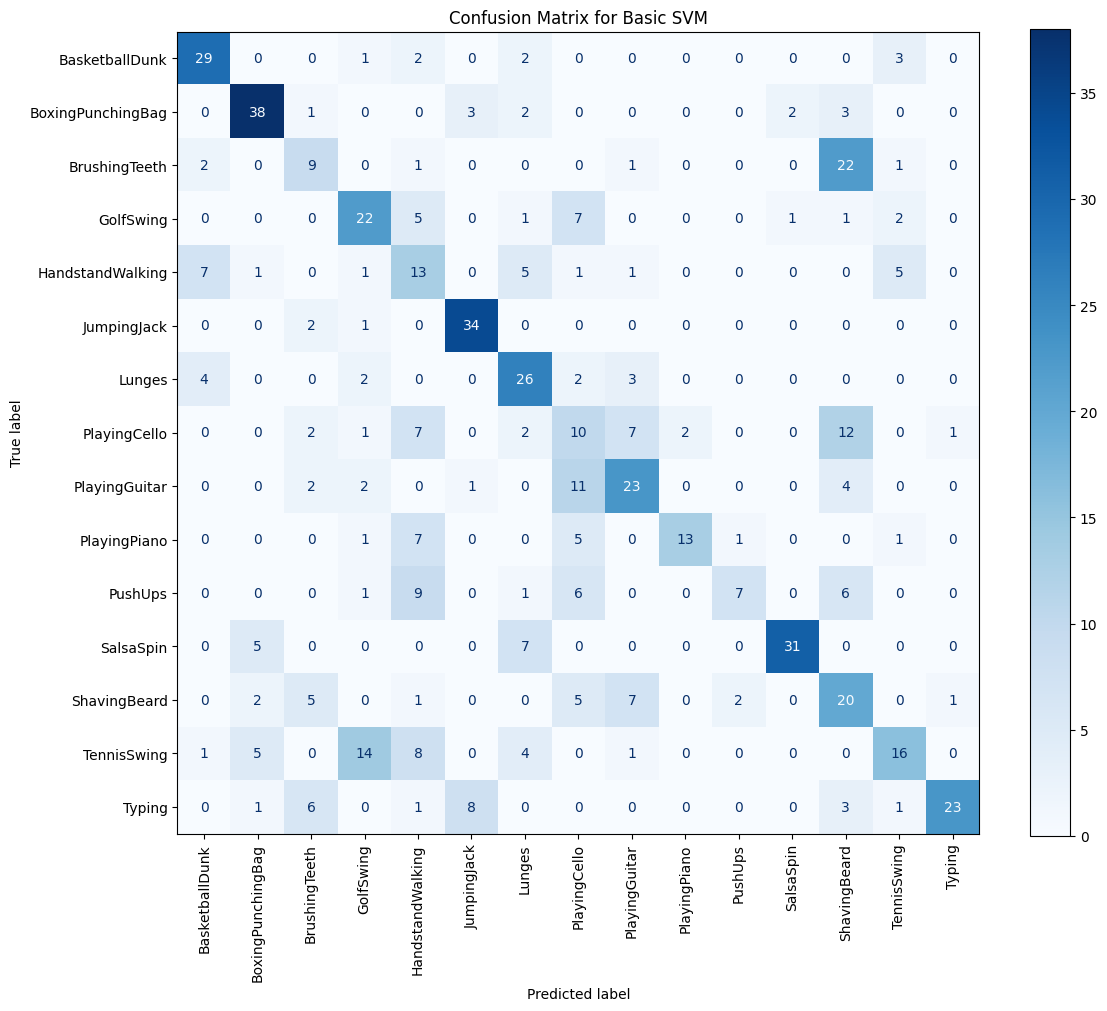


--- 5. Hyperparameter Tuning with GridSearchCV ---
Starting GridSearchCV... This may take a long time.
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................................C=0.1, gamma=scale; total time=   2.5s
[CV] END .................................C=0.1, gamma=scale; total time=   1.8s
[CV] END .................................C=0.1, gamma=scale; total time=   1.8s
[CV] END ..................................C=0.1, gamma=auto; total time=   1.8s
[CV] END ..................................C=0.1, gamma=auto; total time=   1.8s
[CV] END ..................................C=0.1, gamma=auto; total time=   1.8s
[CV] END ..................................C=0.1, gamma=0.01; total time=   2.4s
[CV] END ..................................C=0.1, gamma=0.01; total time=   2.6s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.9s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.9s
[CV] END ................

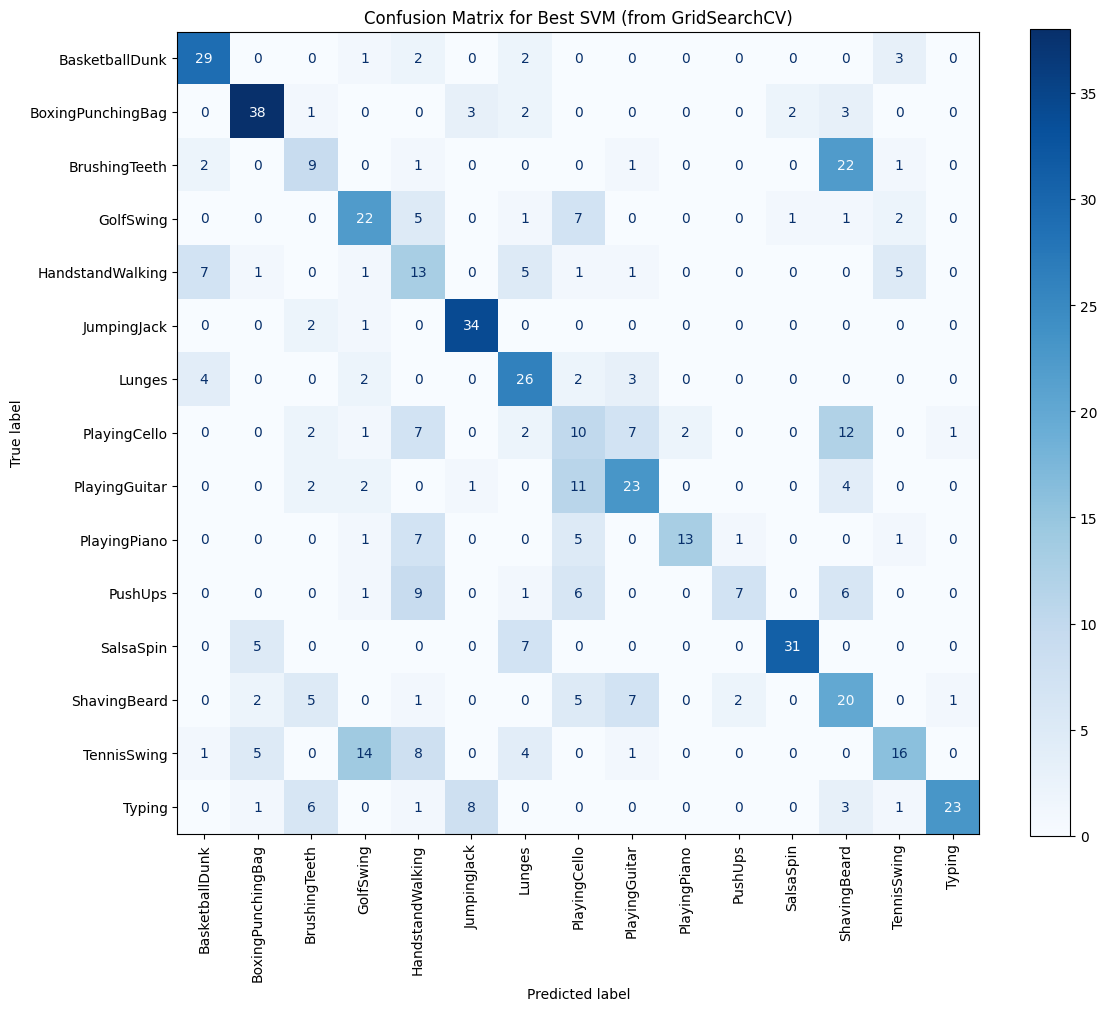


--- Classifier Training and Evaluation Complete (Cell 5) ---
CPU times: user 1min 23s, sys: 161 ms, total: 1min 23s
Wall time: 1min 24s


In [ ]:
%%time
# --- Cell 5: Train and Evaluate Classifier (SVM) ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import time
import gc
import os

print("--- Running: Cell 5 - Train and Evaluate Classifier (SVM) ---")

# --- Define paths (ensure these are consistent with where things were saved/defined) ---
K_VOCAB_SIZE = 500 # Must match how BoVW features were created
VOCAB_DESC_COUNT_FOR_FILENAME = 100000

# Path to where BoVW features were saved by Cell 4
BOVW_FEATURES_SAVE_DIR = '/content/project_data_subset/bovw_features'

# Paths for train/test split lists (needed for labels)
LOCAL_SPLITS_DIR_FOR_USE = '/content/project_data_subset/ucfTrainTestlist_subset' # From Stage 2
TRAIN_LIST_PATH = os.path.join(LOCAL_SPLITS_DIR_FOR_USE, 'trainlist01.txt')
TEST_LIST_PATH = os.path.join(LOCAL_SPLITS_DIR_FOR_USE, 'testlist01.txt')
VIDEO_DIR = '/content/project_data_subset/UCF101_subset_videos' # From Stage 2
CHOSEN_CLASSES = [ # From Stage 2
    'BasketballDunk', 'GolfSwing', 'TennisSwing',
    'PlayingPiano', 'PlayingGuitar', 'PlayingCello',
    'BrushingTeeth', 'Typing', 'ShavingBeard',
    'JumpingJack', 'Lunges', 'PushUps',
    'BoxingPunchingBag', 'SalsaSpin', 'HandstandWalking'
]

# --- Try to load BoVW features and labels ---
print("\n--- Loading BoVW features and labels ---")
try:
    # Load BoVW features
    train_bovw_filename = f'X_train_bovw_k{K_VOCAB_SIZE}_vocabdesc{VOCAB_DESC_COUNT_FOR_FILENAME}.npy'
    test_bovw_filename = f'X_test_bovw_k{K_VOCAB_SIZE}_vocabdesc{VOCAB_DESC_COUNT_FOR_FILENAME}.npy'

    X_train_bovw_path = os.path.join(BOVW_FEATURES_SAVE_DIR, train_bovw_filename)
    X_test_bovw_path = os.path.join(BOVW_FEATURES_SAVE_DIR, test_bovw_filename)

    if os.path.exists(X_train_bovw_path) and os.path.exists(X_test_bovw_path):
        print(f"Loading X_train_bovw from {X_train_bovw_path}")
        X_train_bovw = np.load(X_train_bovw_path)
        print(f"Loading X_test_bovw from {X_test_bovw_path}")
        X_test_bovw = np.load(X_test_bovw_path)
        print("BoVW features loaded successfully.")
    else:
        print(f"ERROR: Saved BoVW .npy files not found in {BOVW_FEATURES_SAVE_DIR}. You might need to re-run Cell 4.")
        raise FileNotFoundError("Saved BoVW .npy files not found.")

    # Re-create labels
    def load_video_list_and_labels(list_file_path, video_base_dir, chosen_classes_list): # Copied from your earlier cell
        video_paths = []
        labels_text = []
        with open(list_file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line: continue
                parts = line.split()
                relative_video_path_from_list = parts[0]
                class_name_from_path = relative_video_path_from_list.split('/')[0]
                if class_name_from_path in chosen_classes_list:
                    full_video_path = os.path.join(video_base_dir, relative_video_path_from_list)
                    if os.path.exists(full_video_path):
                        video_paths.append(full_video_path)
                        labels_text.append(class_name_from_path)
        return video_paths, labels_text

    _, train_labels_text = load_video_list_and_labels(TRAIN_LIST_PATH, VIDEO_DIR, CHOSEN_CLASSES)
    _, test_labels_text = load_video_list_and_labels(TEST_LIST_PATH, VIDEO_DIR, CHOSEN_CLASSES)

    if not train_labels_text or not test_labels_text:
        raise ValueError("Failed to load text labels.")

    label_encoder = LabelEncoder()
    label_encoder.fit(CHOSEN_CLASSES) # Fit on the master list
    train_labels_encoded = label_encoder.transform(train_labels_text)
    test_labels_encoded = label_encoder.transform(test_labels_text)
    print("Labels loaded and encoded successfully.")

except Exception as e:
    print(f"An error occurred during loading: {e}")
    print("Please ensure Cell 4 (BoVW creation) and label encoding steps were run successfully, or that saved files exist.")
    raise

# --- Sanity check again AFTER loading attempts ---
if 'X_train_bovw' not in locals() or 'train_labels_encoded' not in locals() or \
   'X_test_bovw' not in locals() or 'test_labels_encoded' not in locals():
    print("ERROR: BoVW features or labels are still missing after loading attempt.")
    raise NameError("BoVW features or labels could not be loaded.")

if 'label_encoder' not in locals():
    print("ERROR: 'label_encoder' is still missing after loading attempt.")
    raise NameError("'label_encoder' could not be loaded.")

# --- 1. Feature Scaling ---
print("\n--- 1. Scaling BoVW Features ---")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bovw)
X_test_scaled = scaler.transform(X_test_bovw)

print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")
print("BoVW features scaled successfully.")

print("\nCleaning up unscaled BoVW features to save RAM...")
if 'X_train_bovw' in locals(): del X_train_bovw
if 'X_test_bovw' in locals(): del X_test_bovw
gc.collect()
print("Unscaled BoVW features cleaned up.")


# --- 2. Train a Basic SVM Model ---
print("\n--- 2. Training a Basic SVM Model ---")
# Common SVM parameters:
# kernel: 'rbf' (Radial Basis Function) is a good default. Others: 'linear', 'poly', 'sigmoid'.
# C: Regularization parameter. The strength of the regularization is inversely proportional to C.
#    Must be strictly positive. (e.g., 0.1, 1, 10, 100)
# gamma: Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.
#        'scale' (1 / (n_features * X.var())) is a good default.
#        'auto' (1 / n_features) is another option.
# random_state: For reproducibility.
# probability: Set to True if you want to use predict_proba later. Can make fitting slower.

start_time = time.time()
# Initial SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, probability=True, verbose=True)
print(f"Training SVM with parameters: C={svm_classifier.C}, gamma='{svm_classifier.gamma}', kernel='{svm_classifier.kernel}'")

svm_classifier.fit(X_train_scaled, train_labels_encoded)

end_time = time.time()
print(f"Basic SVM training complete. Time taken: {end_time - start_time:.2f} seconds.")

# --- 3. Make Predictions ---
print("\n--- 3. Making Predictions on the Test Set ---")
y_pred_encoded = svm_classifier.predict(X_test_scaled)

# --- 4. Evaluate the Model ---
print("\n--- 4. Evaluating the Basic SVM Model ---")
accuracy = accuracy_score(test_labels_encoded, y_pred_encoded)
print(f"Accuracy on Test Set: {accuracy * 100:.2f}%")

print("\nClassification Report:")

class_names_for_report = label_encoder.classes_
print(classification_report(test_labels_encoded, y_pred_encoded, target_names=class_names_for_report, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(test_labels_encoded, y_pred_encoded, labels=range(len(class_names_for_report)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_for_report)

fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix for Basic SVM')
plt.tight_layout()
plt.show()

# --- 5. Hyperparameter Tuning with GridSearchCV ---
perform_grid_search = True # Set to True to run, False to skip for now

if perform_grid_search:
    print("\n--- 5. Hyperparameter Tuning with GridSearchCV ---")

    # Define the parameter grid to search
    # Example grid, keep it small initially to manage runtime
    param_grid = {
        'C': [0.1, 1, 10],           # Regularization parameter
        'gamma': ['scale', 'auto', 0.01, 0.1], # Kernel coefficient
        # 'kernel': ['rbf', 'linear'] # Can also tune kernel if desired
    }
    # For 'linear' kernel, 'gamma' is not used.

    # Initialize GridSearchCV
    grid_search_svm = SVC(random_state=42, probability=True) # Base estimator
    grid_search = GridSearchCV(estimator=grid_search_svm,
                               param_grid=param_grid,
                               cv=3, # 3-fold cross-validation is a quick start
                               scoring='accuracy',
                               verbose=2,
                               n_jobs=1) # Start with n_jobs=1 for RAM safety

    print("Starting GridSearchCV... This may take a long time.")
    start_time_grid = time.time()
    grid_search.fit(X_train_scaled, train_labels_encoded)
    end_time_grid = time.time()
    print(f"GridSearchCV complete. Time taken: {end_time_grid - start_time_grid:.2f} seconds.")

    print("\nBest Parameters found by GridSearchCV:")
    print(grid_search.best_params_)
    print(f"Best Cross-Validation Accuracy: {grid_search.best_score_ * 100:.2f}%")

    # Get the best estimator
    best_svm_classifier = grid_search.best_estimator_

    # Evaluate the best model from GridSearchCV on the test set
    print("\n--- Evaluating the Best SVM Model from GridSearchCV ---")
    y_pred_best_encoded = best_svm_classifier.predict(X_test_scaled)

    accuracy_best = accuracy_score(test_labels_encoded, y_pred_best_encoded)
    print(f"Accuracy of Best SVM on Test Set: {accuracy_best * 100:.2f}%")

    print("\nClassification Report for Best SVM:")
    print(classification_report(test_labels_encoded, y_pred_best_encoded, target_names=class_names_for_report, zero_division=0))

    print("\nConfusion Matrix for Best SVM:")
    cm_best = confusion_matrix(test_labels_encoded, y_pred_best_encoded, labels=range(len(class_names_for_report)))
    disp_best = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=class_names_for_report)

    fig_best, ax_best = plt.subplots(figsize=(12, 10))
    disp_best.plot(ax=ax_best, cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title('Confusion Matrix for Best SVM (from GridSearchCV)')
    plt.tight_layout()
    plt.show()

    # Clean up GridSearchCV object if large
    # del grid_search
    # gc.collect()
else:
    print("\nSkipping GridSearchCV for hyperparameter tuning (perform_grid_search is False).")

print("\n--- Classifier Training and Evaluation Complete (Cell 5) ---")